---

# **Recognizing Malingery in a Personality Disorder Test**
##### The dataset that we used comes from a psychological experiment in which 412 people were asked to answer two times the same questionnaire, the first time in an honest way and the second time in a dishonest way, in order to see if there are significative differences between the two behaviors and eventually develop a strategy to distinguish the two. The questionnaire used in this experiment is the PID-5, a questionnaire used to identify several personality traits. Our aim is to recognize dishonest objects in these kinds of datasets. To reach this goal we tried, $penalized$ $logistic$ $regression$, $group$ $lasso$, $sparse$ $SVM$ and $sparse$ $PCA$ methods and in the following we will see the results.

---

# 0 Libraries

In [1]:
library(tidyverse)
library(GGally)

library(glmnet)

library(sparseSVM)

install.packages("sparsepca")
library(sparsepca)

install.packages("gglasso")
library(gglasso)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘rsvd’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# 1 Dataset

In [2]:
df = read.csv(file = '../input/pid5-df/PID5_df.csv', sep=';')
head(df)

Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8 Q9 Q10 ⋯ Q212 Q213 Q214 Q215 Q216 Q217 Q218 Q219 Q220
1 0  0  2  2  0  0  2  0  0  1   ⋯ 0    0    2    2    2    0    0    0    2   
2 0  1  1  2  2  1  1  0  1  0   ⋯ 3    0    1    2    1    0    1    0    1   
3 1  0  0  1  1  1  2  1  2  1   ⋯ 2    2    2    2    1    1    2    1    2   
4 2  0  1  2  2  2  2  0  2  1   ⋯ 2    2    1    2    0    0    2    0    1   
5 2  0  0  0  1  1  1  0  2  1   ⋯ 2    1    0    1    0    0    0    0    1   
6 1  1  1  1  2  2  1  1  2  1   ⋯ 2    2    3    1    1    1    2    1    0   
  CONDITION
1 H        
2 H        
3 H        
4 H        
5 H        
6 H

The dataset is composed of 220 questions, each one with an associated score ranging from 0 to 3. The final column of the dataset represents the dependent variable (namely the condition of the responder, honest or dishonest). This dataset contains 924 objects that 412 of them are honest and 412 are dishonest answers it also included 100 extra observations of pathological individuals (to be considered as an extra condition), but since that third class contained way less observations than the first two with respect to the other two, we decided to exclude it from our project and stick with the first two conditions, therefore facing a binary classification problem.

In [3]:
# We need only honests and dishonests
df_h <- df %>% filter(df$CONDITION == "H")
df_d <- df %>% filter(df$CONDITION == "D")
head(df_h)
head(df_d)

Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8 Q9 Q10 ⋯ Q212 Q213 Q214 Q215 Q216 Q217 Q218 Q219 Q220
1 0  0  2  2  0  0  2  0  0  1   ⋯ 0    0    2    2    2    0    0    0    2   
2 0  1  1  2  2  1  1  0  1  0   ⋯ 3    0    1    2    1    0    1    0    1   
3 1  0  0  1  1  1  2  1  2  1   ⋯ 2    2    2    2    1    1    2    1    2   
4 2  0  1  2  2  2  2  0  2  1   ⋯ 2    2    1    2    0    0    2    0    1   
5 2  0  0  0  1  1  1  0  2  1   ⋯ 2    1    0    1    0    0    0    0    1   
6 1  1  1  1  2  2  1  1  2  1   ⋯ 2    2    3    1    1    1    2    1    0   
  CONDITION
1 H        
2 H        
3 H        
4 H        
5 H        
6 H

Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8 Q9 Q10 ⋯ Q212 Q213 Q214 Q215 Q216 Q217 Q218 Q219 Q220
1 2  2  3  2  3  1  3  2  2  2   ⋯ 1    3    0    2    2    3    0    0    1   
2 2  2  0  2  2  2  1  2  0  3   ⋯ 0    3    2    1    1    3    1    1    2   
3 3  3  3  3  3  3  3  3  3  3   ⋯ 0    3    3    3    3    3    3    3    3   
4 3  3  3  2  2  3  3  3  3  0   ⋯ 3    3    3    3    3    3    3    3    0   
5 3  3  3  3  3  3  3  3  3  3   ⋯ 2    3    3    2    3    3    3    3    2   
6 3  2  3  3  2  2  3  3  1  3   ⋯ 3    3    1    3    1    3    0    1    3   
  CONDITION
1 D        
2 D        
3 D        
4 D        
5 D        
6 D

# 2 EDA

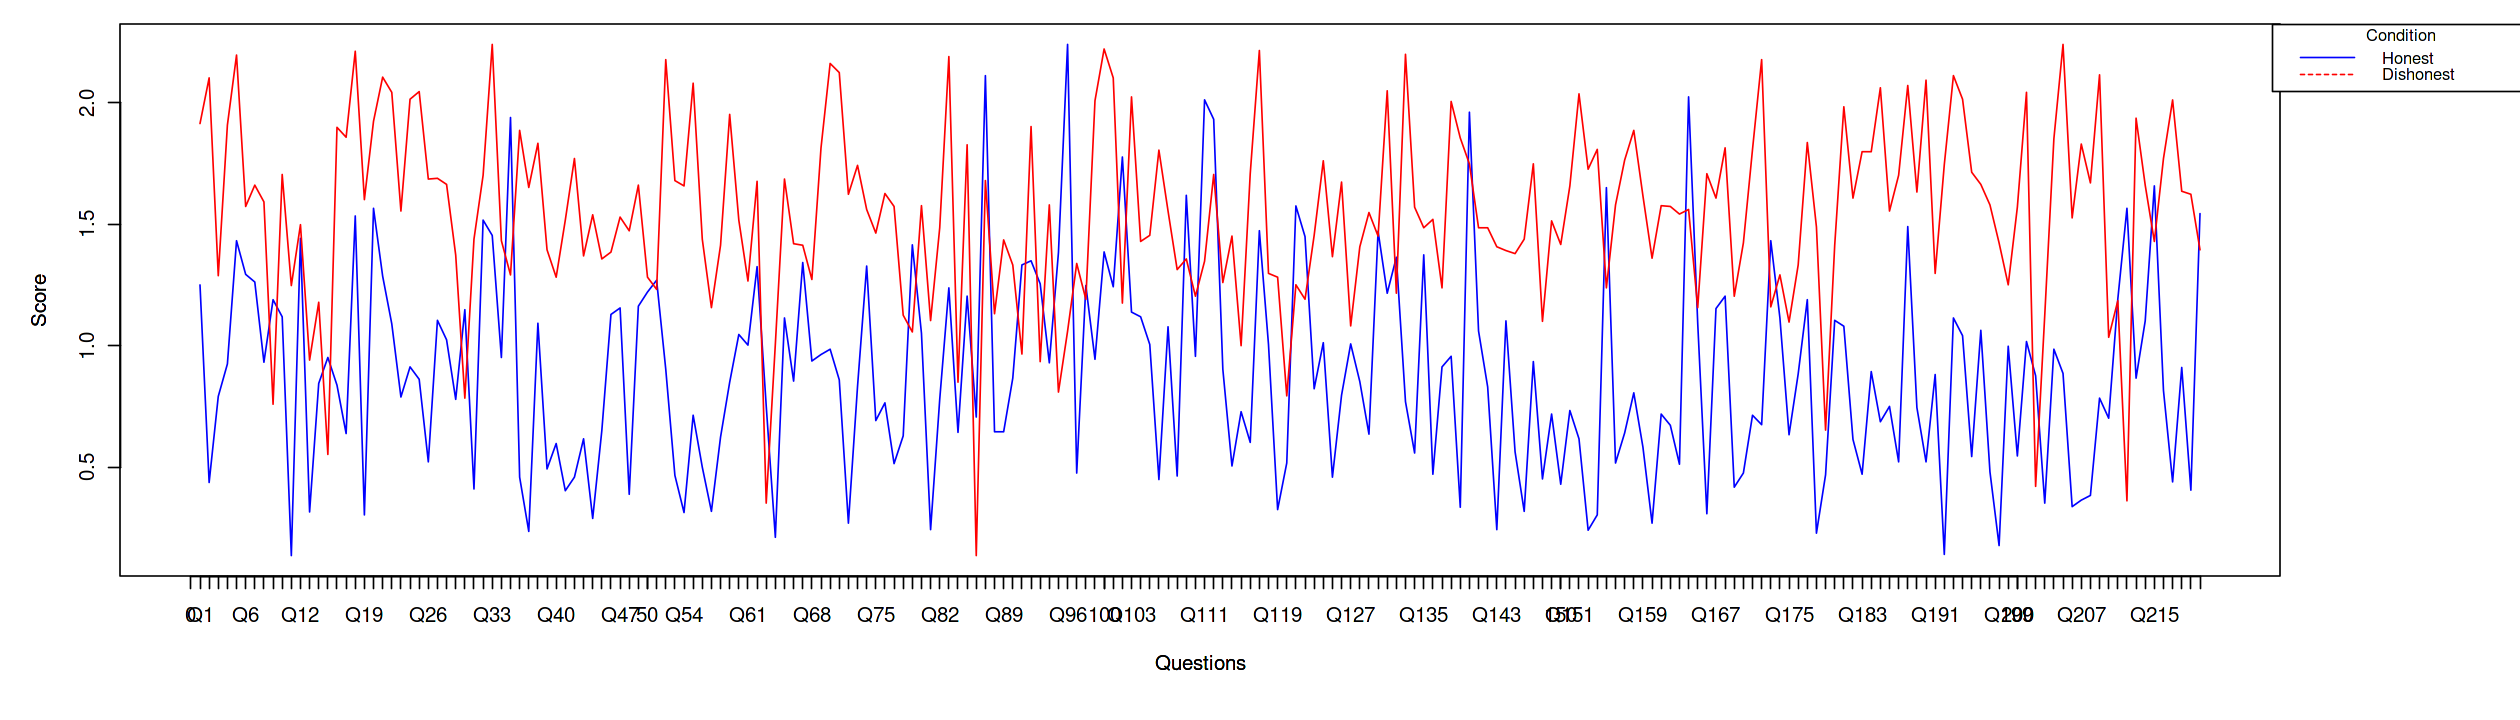

In [4]:
# Plot average values
options(repr.plot.width=21, repr.plot.height=6)

par(mar=c(6, 5, 1, 10), xpd=TRUE) # (bottom, left, top, and right.)
plot(colMeans(df_h[-ncol(df_h)]), type='l', xlab='Questions', ylab='Score', col="blue")
par(new=T)
plot(colMeans(df_d[-ncol(df_d)]), type='l', xlab='Questions', ylab='Score', axes=F, col="red")
par(new=F)
axis(1, at=1:220, labels=colnames(df[-ncol(df)]))
legend("topright", inset=c(-0.115, 0), legend=c("Honest", "Dishonest"), col=c("blue", "red"), lty=1:2, cex=0.8, title="Condition")

As we can see in the figure above, which represents the average patterns for the honest and dishonest groups, there seems to be a distinction between these two with some questions being more significant than others in distinguishing them, and thus running some variable-selecting algorithms seems the best choice to optimize the overall performance. Unfortunately other EDA analysis techniques like plotting a correlation matrix or frequency tables are not feasible with such a large number of features.

In order to avoid overfitting we divided the dataset into a training and a test set (while making sure that the distribution of the two conditions remained the same in the two subsets) and we used the first one to fit the models and run cross-validation, and the second one to get an estimate of the accuracy of the model.

In [5]:
# Split dataset in train and test
df_hd <- df %>% filter(df$CONDITION == "H" | df$CONDITION == "D")
df_hd$CONDITION = as.factor(df_hd$CONDITION)

x = as.matrix(df_hd[-ncol(df_hd)])
y = as.numeric(df_hd$CONDITION)
y = replace(y, y==2, -1)
set.seed(123)

train_ind = sample(length(y), size=floor(length(y)*0.75), replace = FALSE)

x_train = x[train_ind, ]
y_train = y[train_ind]

x_test = x[-train_ind, ]
y_test = y[-train_ind]

# 3 Models

## 3.1 Penalized logistic regression

Since  we face  a binary classification problem, one of the best models that  we can use is logistic regression. But logistic regression often gets problems with degeneracies for high dimensional data. To reduce this issue we need to consider regularization. For this aim we can use the Glmnet package which  enables us to consider the  elastic net penalty. 

The  logistic regression objective function is :
\begin{equation}
\label{eq:penlogreg}
 \underset{(\beta_{0}, \beta) \in \mathbb{R}^{p + 1}}{\min} \ - \left[ \frac{1}{N} \sum_{i=1}^{N} y_{i} (\beta_{0}+x_{i}^{T}\beta) - log(1+e^{(\beta_{0}+x_{i}^{T})}) \right] +\lambda \left[ \frac{(1-\alpha) \Vert \beta \Vert_{2}^{2}}{2} +\alpha \Vert \beta \Vert_{1} \right]   
\end{equation}

Which is the penalized negative binomial log-likelihood. We can control the elastic net penalty through $\alpha$, and move between lasso regression ($\alpha$ = 1) and ridge regression ($\alpha$ = 0). The tuning parameter $\lambda$ controls the overall strength of the penalty. We tried logistic regression for three different values of $\alpha$=1 for lasso, $\alpha$=0 for ridge and $\alpha$=0.5 which mixes these two. In the following, we will take a look at the results and make the comparison.

In [6]:
# First for all three alphas we run cross-validation and compare the missclissification Errors
# alpha=1~lasso
# alpha==0.5~elastic net
# alpha=0~ridge

cvlasso <- cv.glmnet(x_train, y_train,alpha=1, standardize=FALSE,family = "binomial", type.measure = "class")
cvelasticnet <- cv.glmnet(x_train, y_train,alpha=0.5, standardize=FALSE,family = "binomial", type.measure = "class")
cvridge <- cv.glmnet(x_train, y_train, alpha=0,standardize=FALSE,family = "binomial", type.measure = "class")

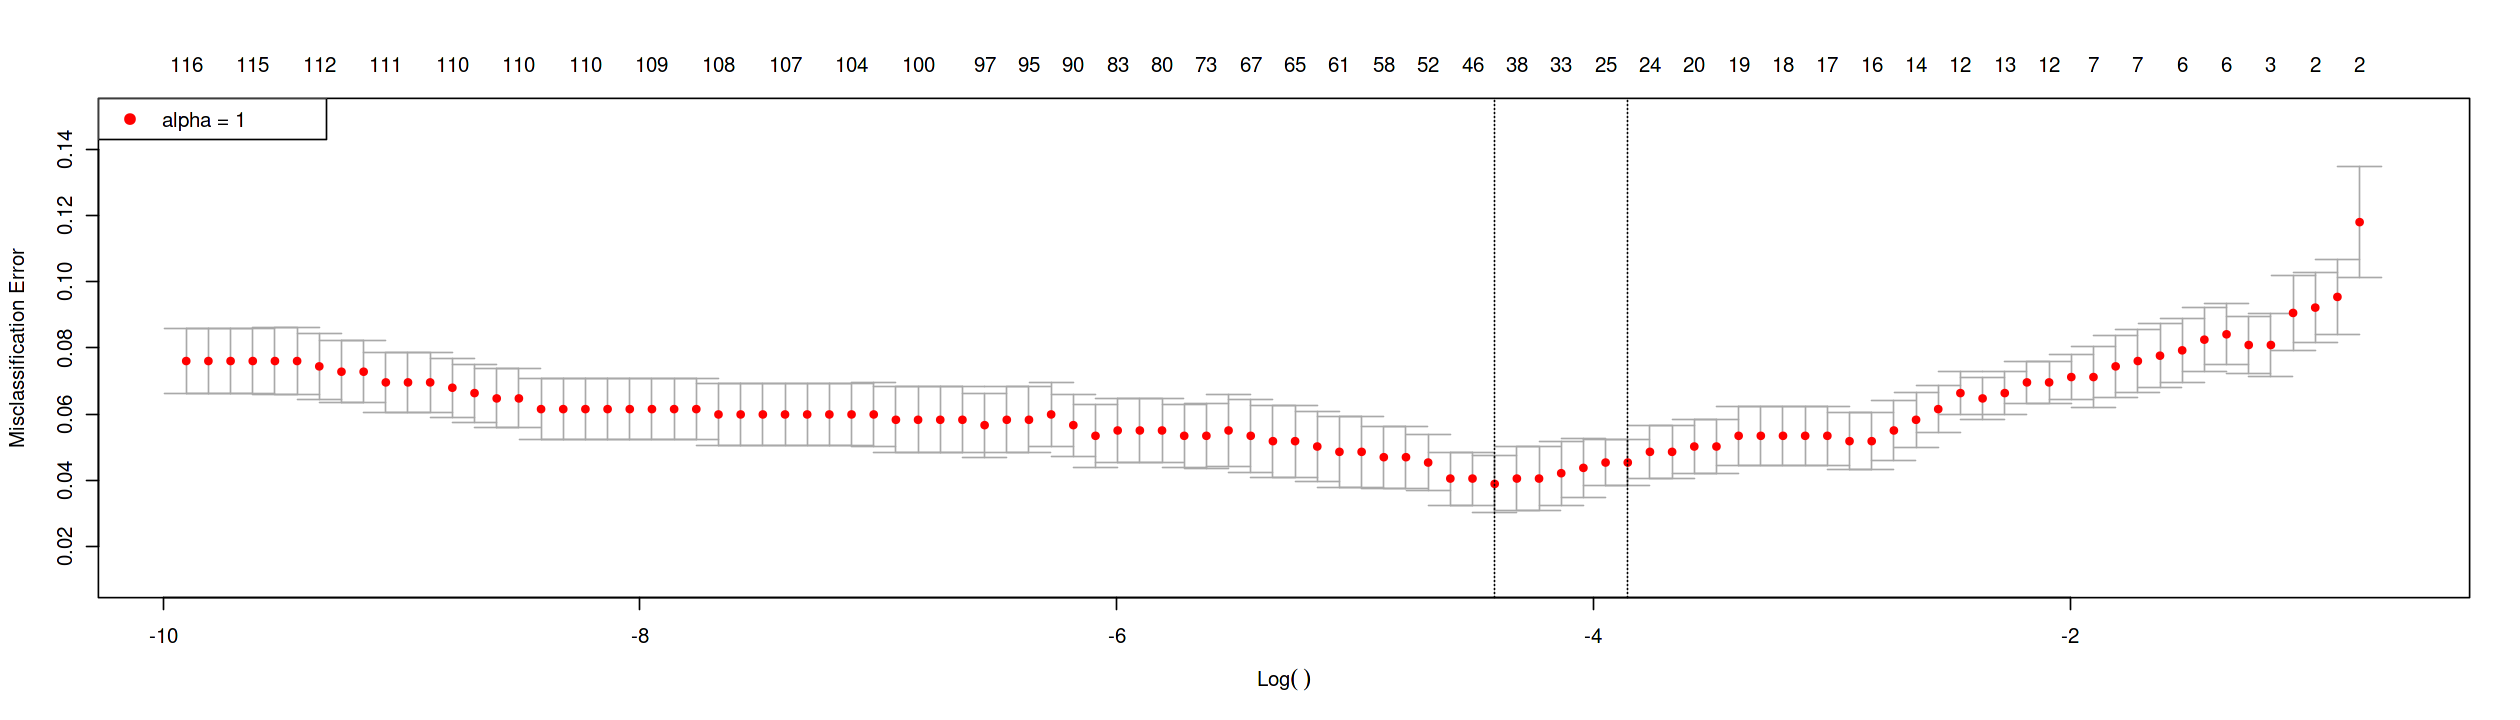

In [7]:
plot(cvlasso,ylim=c(0.01,0.15))
legend("topleft", legend = c("alpha = 1"),pch = 19,col=c("red"))

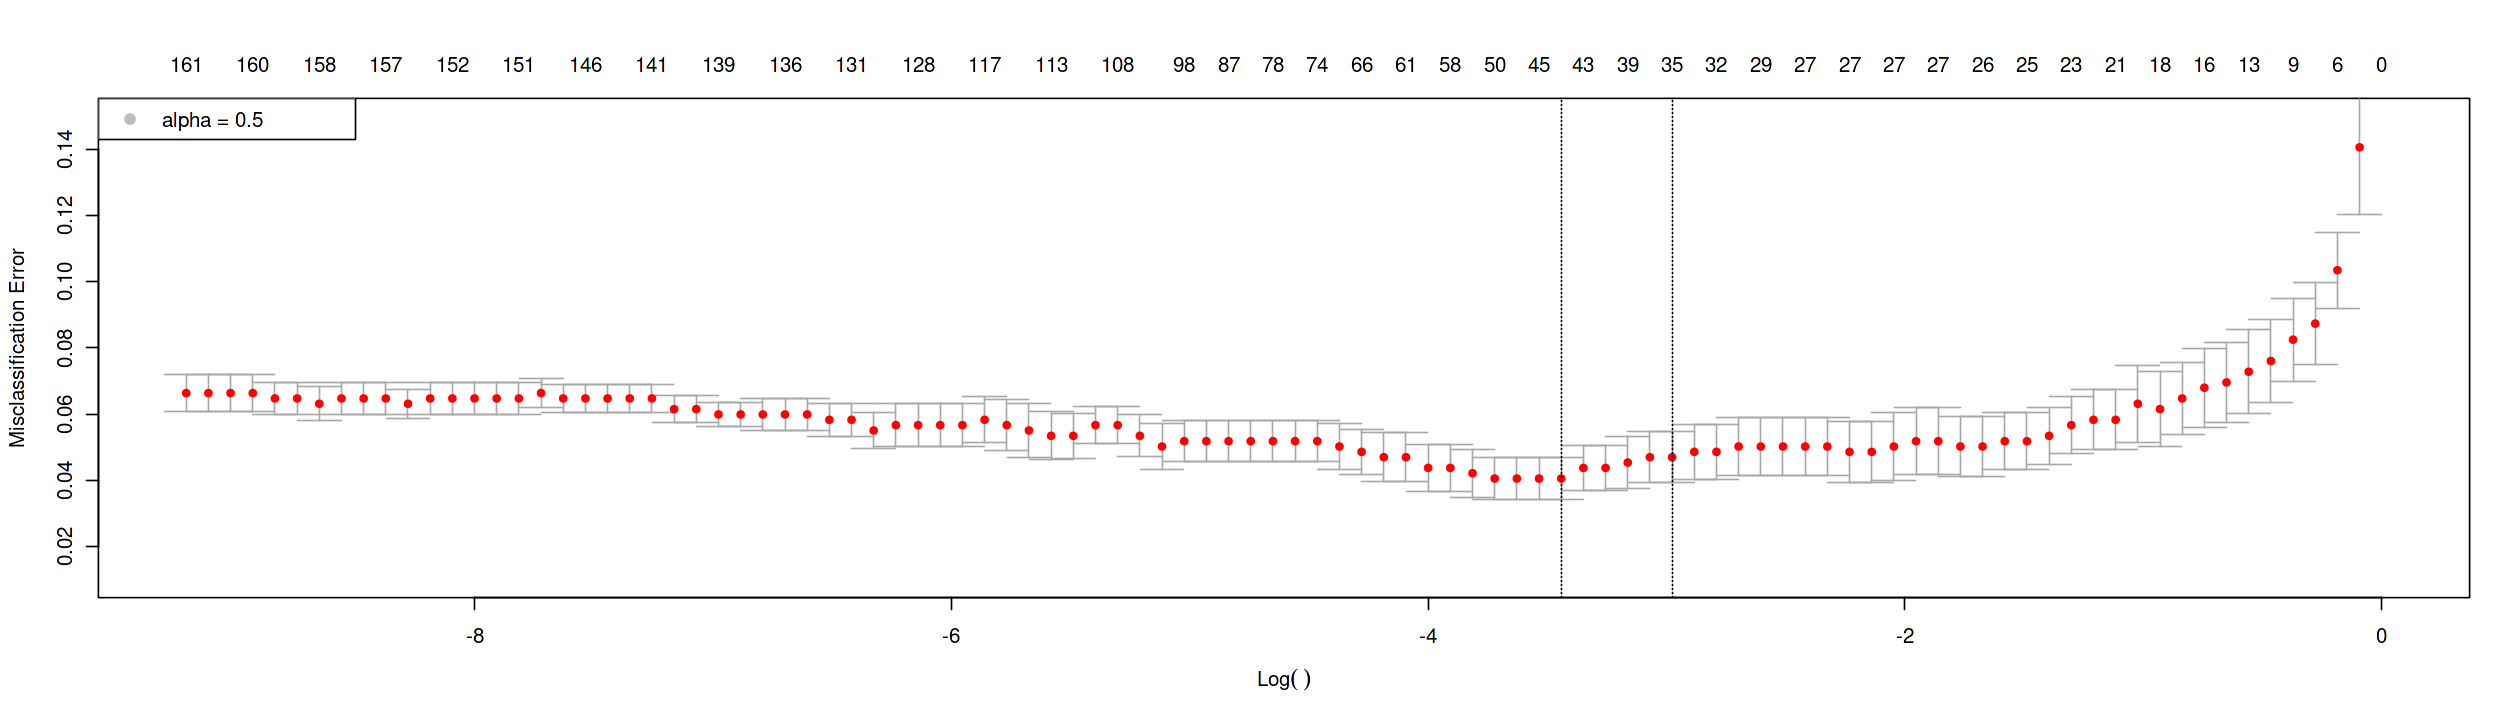

In [8]:
plot(cvelasticnet,ylim=c(0.01,0.15))
legend("topleft", legend = c("alpha = 0.5"),pch = 19,col=c("grey"))

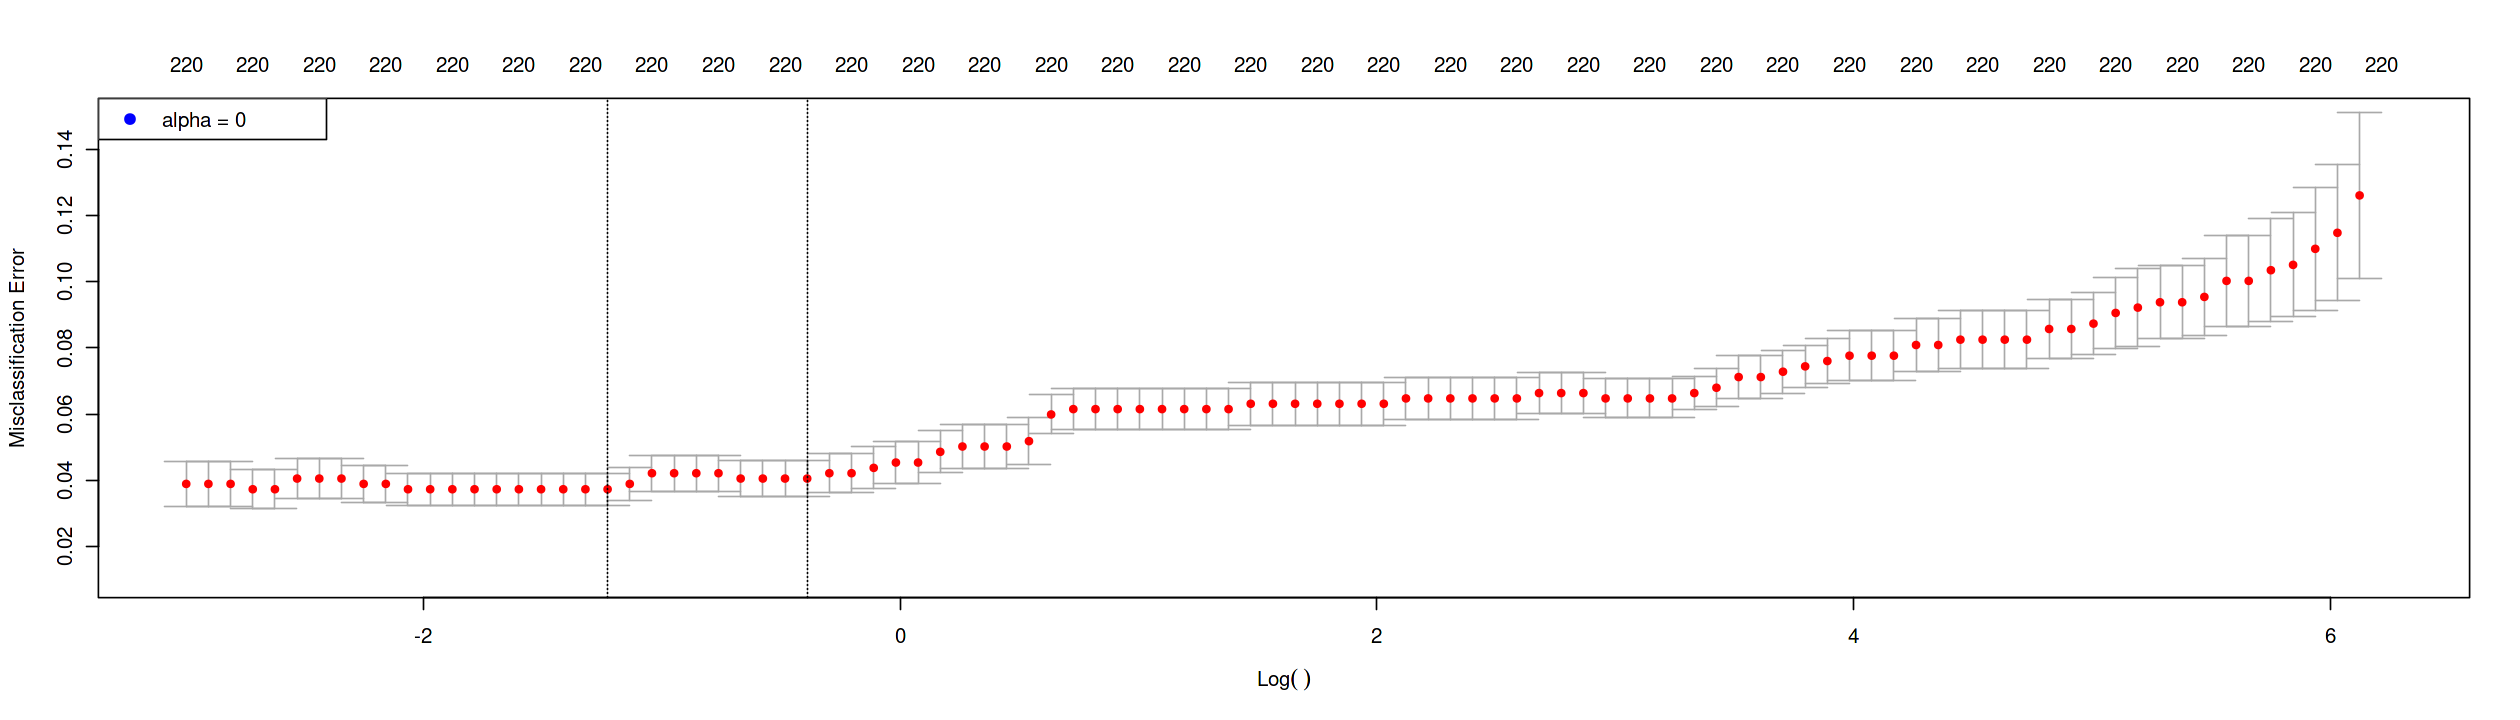

In [9]:
plot(cvridge,ylim=c(0.01,0.15) )
legend("topleft", legend = c("alpha = 0"),pch = 19,col=c("blue"))

These plots display the cross-validation error according to the log of lambda. The left dashed vertical lines indicate the log of the optimal value of lambda, which is the one that minimizes the prediction error. This lambda value will give the most accurate model (best lambda) for each $\alpha$.

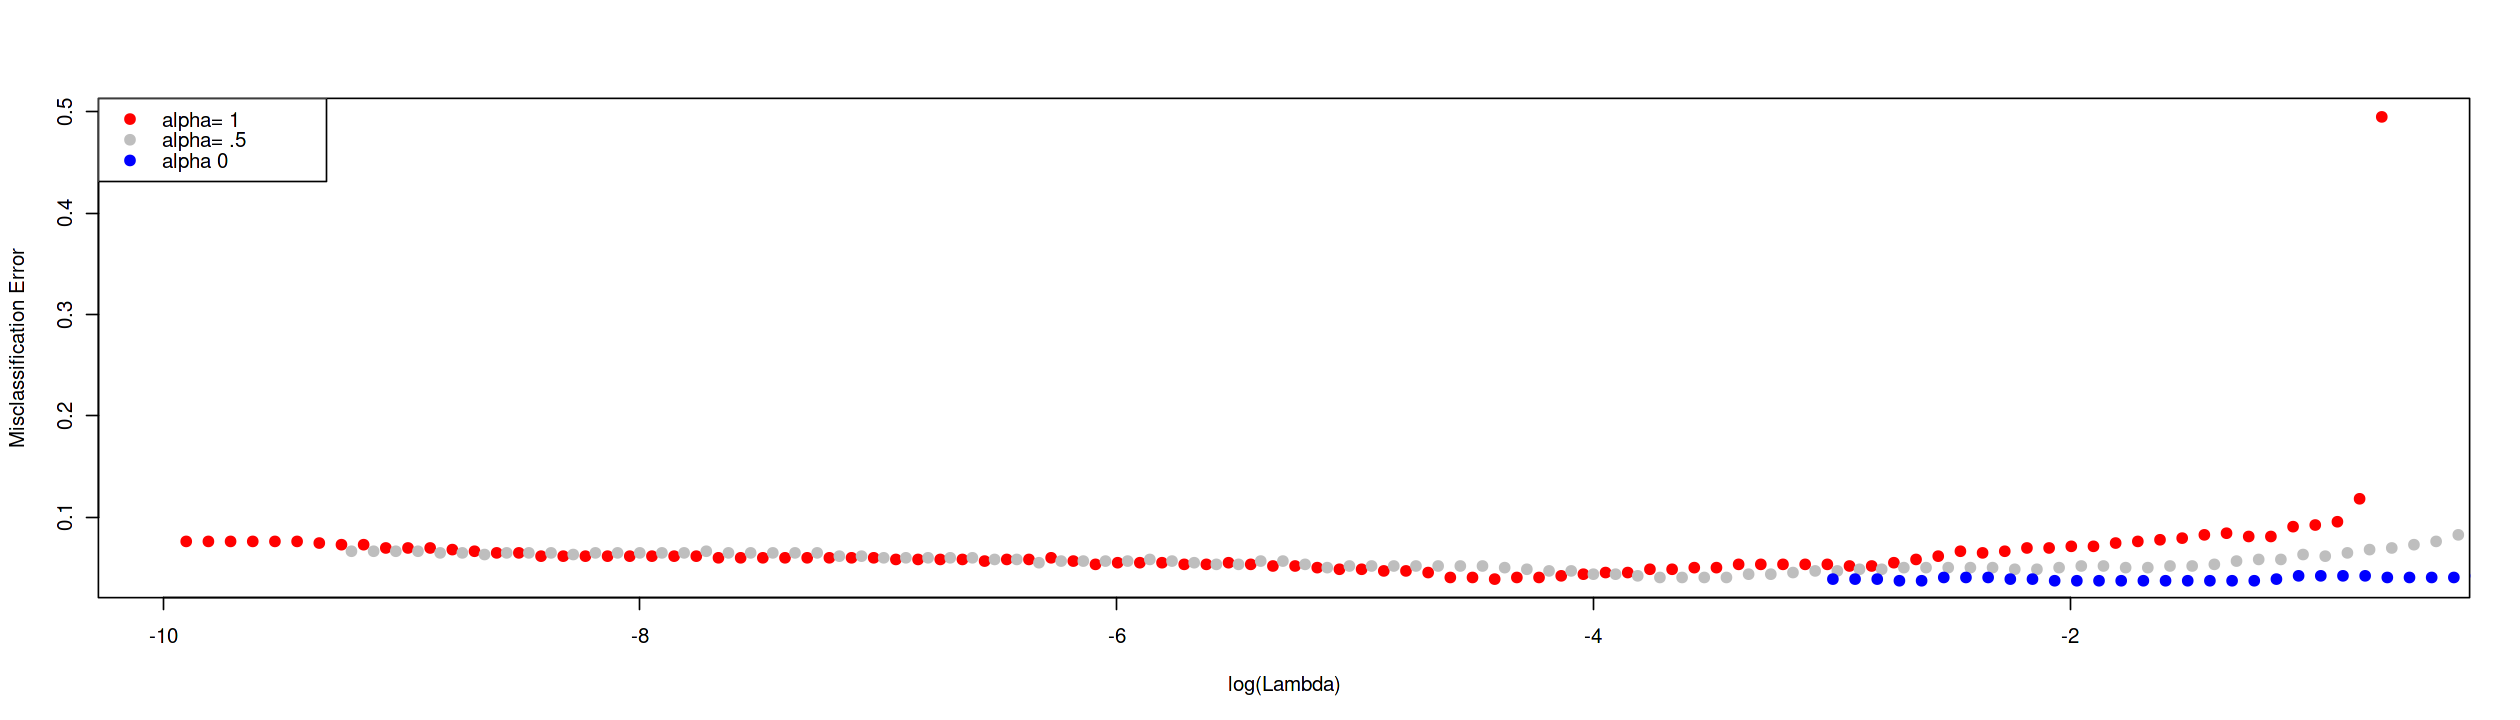

In [10]:
plot(log(cvlasso$lambda), cvlasso$cvm, pch = 19, col = "red", xlab = "log(Lambda)", ylab = cvlasso$name)
points(log(cvelasticnet$lambda), cvelasticnet$cvm, pch = 19, col = "grey")
points(log(cvridge $lambda), cvridge$cvm, pch = 19, col = "blue")
legend("topleft", legend = c("alpha= 1", "alpha= .5", "alpha 0"), pch = 19, col = c("red","grey","blue"))


Call:  cv.glmnet(x = x_train, y = y_train, type.measure = "class", alpha = 1,      standardize = FALSE, family = "binomial") 

Measure: Misclassification Error 

     Lambda Index Measure       SE Nonzero
min 0.01211    41 0.03883 0.008721      43
1se 0.02116    35 0.04531 0.007099      24


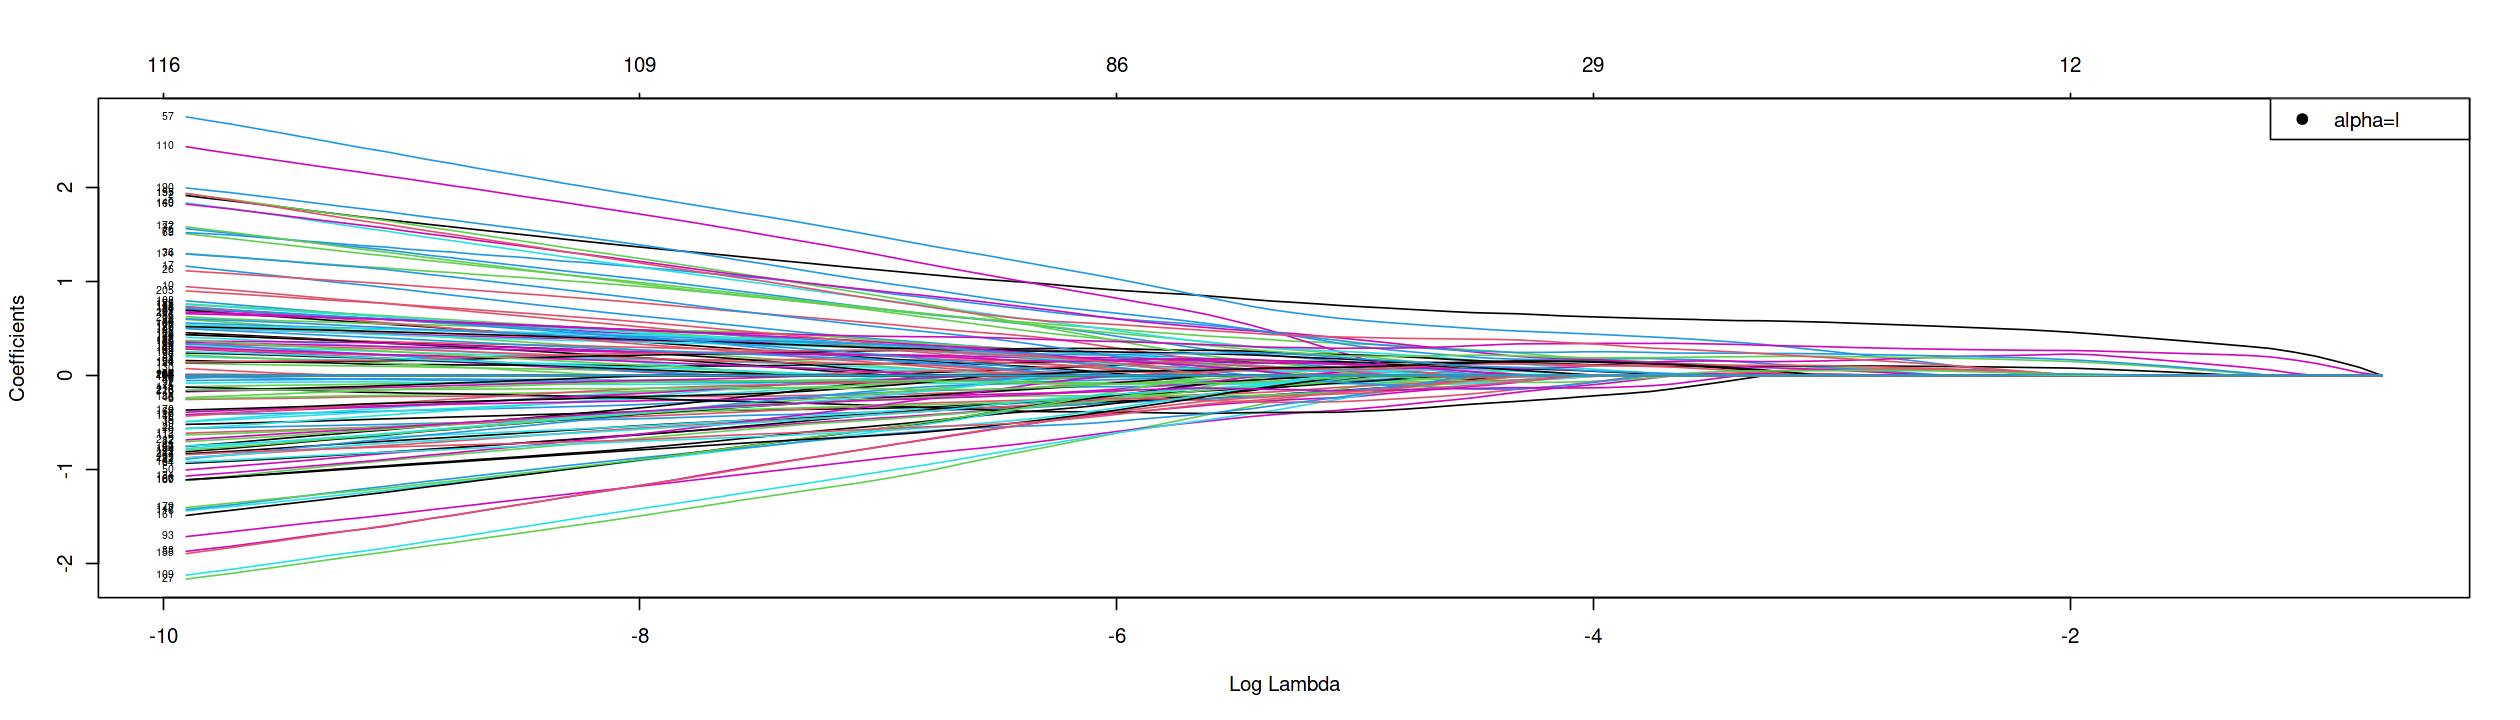

In [11]:
# alpha=1~Lasso, type=class
fit.l <- glmnet(x_train, y_train, alpha=1,standardize=FALSE, family = "binomial",lable=True)

# Looking in to Lambdas
plot(fit.l, xvar = "lambda", label = TRUE)
legend("topright", legend = c("alpha=l"), pch = 19)

# Finding best Lambda based on crossvalidation
print(cvlasso)

In [12]:
# Lasso with lambda.1se
m1 <- glmnet(x_train, y_train, alpha = 1, standardize=FALSE,family = "binomial",lambda = cvlasso$lambda.1se)
predict.m1<-predict(m1, newx = x_test, type = "class", s =cvlasso$lambda.1se)
table(predict.m1, y_test)

          y_test
predict.m1  -1   1
        -1  96   7
        1    3 100

In [13]:
cat("ACCURACY HONEST", 100*100/107,"%\n")
cat("ACCURACY DISHONEST", 96*100/99,"%\n")
cat("TOTAL ACCURACY", (100+96)*100/(206))

ACCURACY HONEST 93.45794 %
ACCURACY DISHONEST 96.9697 %
TOTAL ACCURACY 95.14563

In [14]:
# List of selected features
rownames(coef(cvlasso, s = 'lambda.1se'))[coef(cvlasso, s = 'lambda.1se')[,1]!= 0]

[1] "(Intercept)" "Q2"          "Q34"         "Q36"         "Q57"        
 [6] "Q64"         "Q72"         "Q93"         "Q96"         "Q111"       
[11] "Q112"        "Q132"        "Q149"        "Q153"        "Q154"       
[16] "Q160"        "Q172"        "Q178"        "Q187"        "Q190"       
[21] "Q192"        "Q195"        "Q203"        "Q208"        "Q212"

In [15]:
# Lasso with lambda.min
m1.min <- glmnet(x_train, y_train, alpha = 1,standardize=FALSE, family = "binomial",lambda = cvlasso$lambda.min)
predict.m1.min<-predict(m1.min, newx = x_test, type = "class", s =cvlasso$lambda.min)

table(predict.m1.min, y_test)

              y_test
predict.m1.min  -1   1
            -1  98   6
            1    1 101

In [16]:
cat("ACCURACY HONEST", 101*100/107,"%\n")
cat("ACCURACY DISHONEST", 98*100/99,"%\n")
cat("TOTAL ACCURACY", (101+98)*100/(206))

ACCURACY HONEST 94.39252 %
ACCURACY DISHONEST 98.9899 %
TOTAL ACCURACY 96.60194

In [17]:
# List of selected features
rownames(coef(cvlasso, s = 'lambda.min'))[coef(cvlasso, s = 'lambda.min')[,1]!= 0]

[1] "(Intercept)" "Q2"          "Q5"          "Q9"          "Q17"        
 [6] "Q32"         "Q33"         "Q34"         "Q35"         "Q36"        
[11] "Q37"         "Q57"         "Q64"         "Q69"         "Q72"        
[16] "Q81"         "Q93"         "Q95"         "Q96"         "Q109"       
[21] "Q111"        "Q112"        "Q132"        "Q133"        "Q144"       
[26] "Q149"        "Q153"        "Q154"        "Q155"        "Q160"       
[31] "Q169"        "Q172"        "Q175"        "Q176"        "Q177"       
[36] "Q178"        "Q187"        "Q190"        "Q192"        "Q195"       
[41] "Q203"        "Q208"        "Q212"        "Q214"


Call:  cv.glmnet(x = x_train, y = y_train, type.measure = "class", alpha = 0.5,      standardize = FALSE, family = "binomial") 

Measure: Misclassification Error 

     Lambda Index Measure       SE Nonzero
min 0.03201    38 0.04045 0.006476      45
1se 0.05097    33 0.04693 0.007765      35


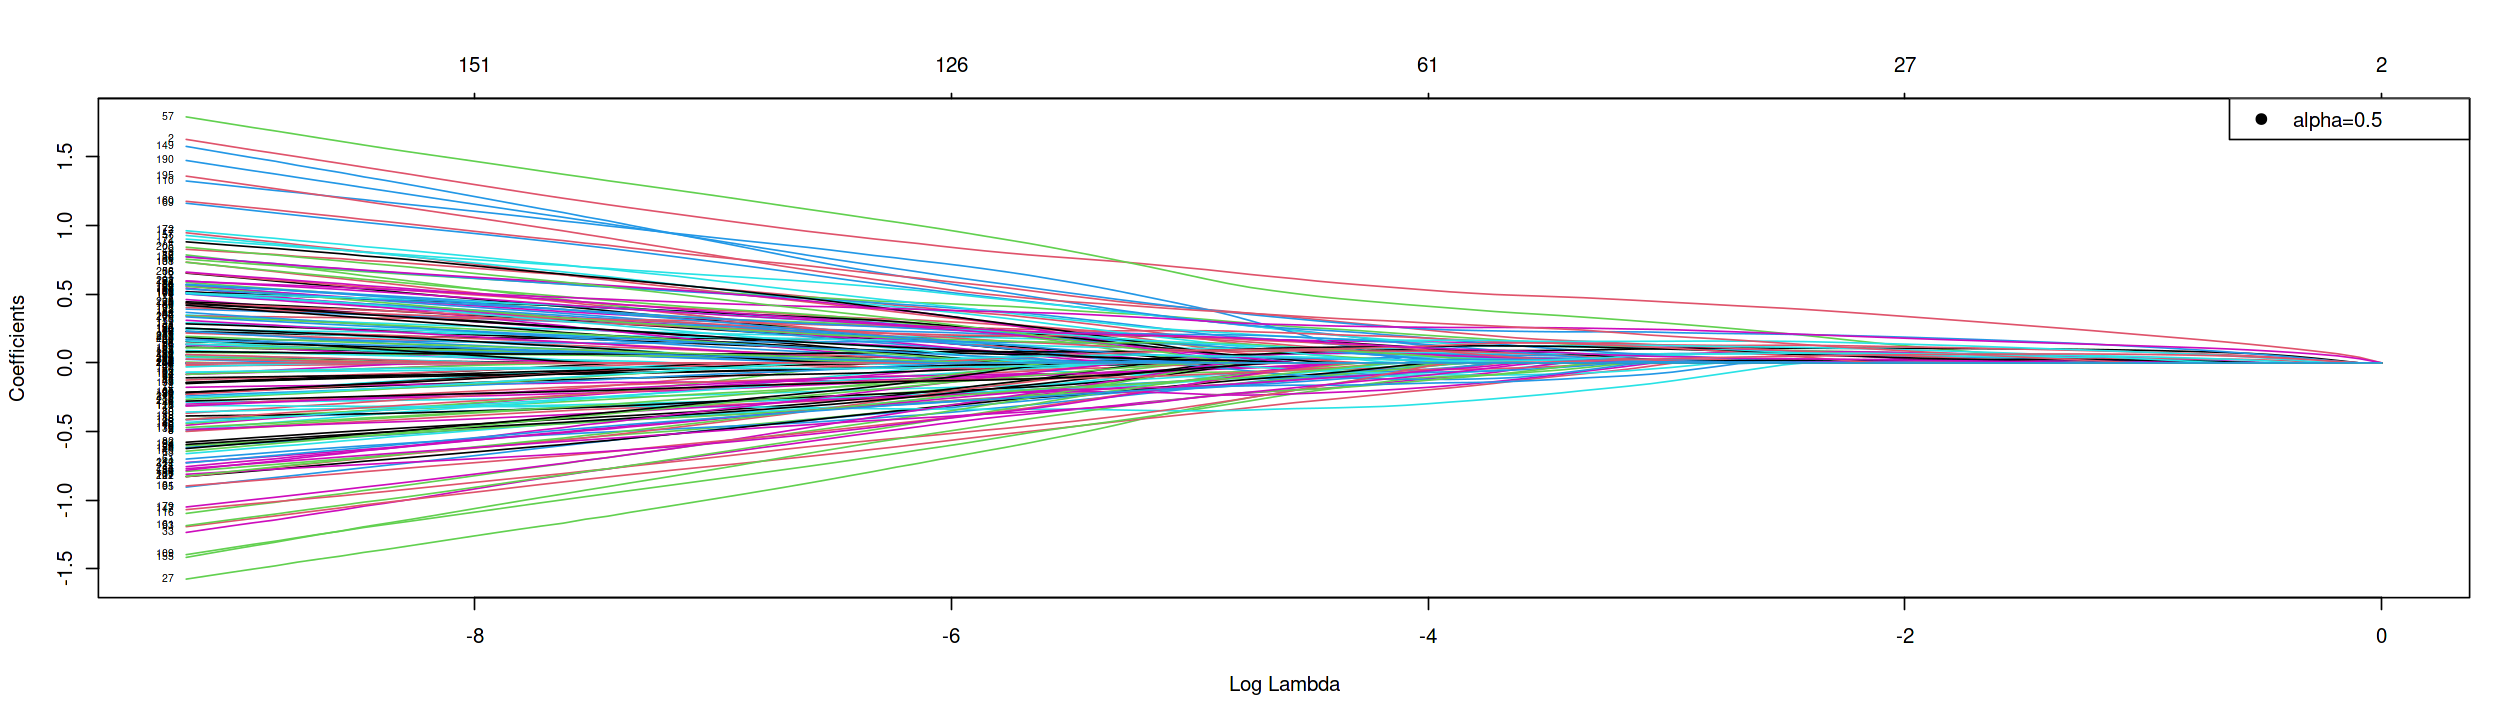

In [18]:
# alpha=0.5 Elastic net
fit.e <- glmnet(x_train, y_train,alpha=0.5,standardize=FALSE, family = "binomial",lable=True)

# Looking in to lambdas
plot(fit.e, xvar = "lambda", label = TRUE)
legend("topright", legend = c("alpha=0.5"), pch = 19)

# Finding best Lambda based on crossvalidation
print(cvelasticnet)

In [19]:
# Elastic net with lambda.1se
m2 <- glmnet(x_train, y_train, alpha = 0.5,standardize=FALSE,family = "binomial",lambda = cvelasticnet$lambda.1se)
predict.m2<-predict(m2, newx = x_test, type = "class", s =cvelasticnet$lambda.1se)

table(predict.m2, y_test)

          y_test
predict.m2  -1   1
        -1  96   7
        1    3 100

In [20]:
cat("ACCURACY HONEST", 102*100/107,"%\n")
cat("ACCURACY DISHONEST", 96*100/99,"%\n")
cat("TOTAL ACCURACY", (102+96)*100/(206))

ACCURACY HONEST 95.3271 %
ACCURACY DISHONEST 96.9697 %
TOTAL ACCURACY 96.1165

In [21]:
# List of selected features
rownames(coef(cvelasticnet, s = 'lambda.1se'))[coef(cvelasticnet, s = 'lambda.1se')[,1]!= 0]

[1] "(Intercept)" "Q2"          "Q17"         "Q19"         "Q26"        
 [6] "Q34"         "Q36"         "Q37"         "Q44"         "Q45"        
[11] "Q54"         "Q57"         "Q64"         "Q72"         "Q93"        
[16] "Q96"         "Q111"        "Q133"        "Q149"        "Q153"       
[21] "Q154"        "Q160"        "Q166"        "Q172"        "Q175"       
[26] "Q178"        "Q187"        "Q190"        "Q192"        "Q195"       
[31] "Q198"        "Q203"        "Q207"        "Q208"        "Q212"       
[36] "Q217"

In [22]:
# Elastic net with lambda.min
m2.min <- glmnet(x_train, y_train, alpha = 0.5,standardize=FALSE ,family = "binomial",lambda = cvelasticnet$lambda.min)
predict.m2.min<-predict(m2.min, newx = x_test, type = "class", s =cvelasticnet$lambda.min)

table(predict.m2.min, y_test)

              y_test
predict.m2.min  -1   1
            -1  96   5
            1    3 102

In [23]:
cat("ACCURACY HONEST", 102*100/107,"%\n")
cat("ACCURACY DISHONEST", 98*100/99,"%\n")
cat("TOTAL ACCURACY", (102+98)*100/(206))

ACCURACY HONEST 95.3271 %
ACCURACY DISHONEST 98.9899 %
TOTAL ACCURACY 97.08738

In [24]:
# List of selected features
rownames(coef(cvelasticnet, s = 'lambda.min'))[coef(cvelasticnet, s = 'lambda.min')[,1]!= 0]

[1] "(Intercept)" "Q2"          "Q17"         "Q19"         "Q26"        
 [6] "Q32"         "Q34"         "Q35"         "Q36"         "Q37"        
[11] "Q44"         "Q45"         "Q54"         "Q57"         "Q64"        
[16] "Q69"         "Q72"         "Q81"         "Q93"         "Q95"        
[21] "Q96"         "Q109"        "Q111"        "Q112"        "Q132"       
[26] "Q133"        "Q149"        "Q153"        "Q154"        "Q155"       
[31] "Q160"        "Q169"        "Q172"        "Q175"        "Q177"       
[36] "Q178"        "Q187"        "Q190"        "Q192"        "Q195"       
[41] "Q198"        "Q203"        "Q207"        "Q208"        "Q212"       
[46] "Q217"


Call:  cv.glmnet(x = x_train, y = y_train, type.measure = "class", alpha = 0,      standardize = FALSE, family = "binomial") 

Measure: Misclassification Error 

    Lambda Index Measure       SE Nonzero
min 0.2930    81 0.03722 0.004844     220
1se 0.6769    72 0.04045 0.005486     220


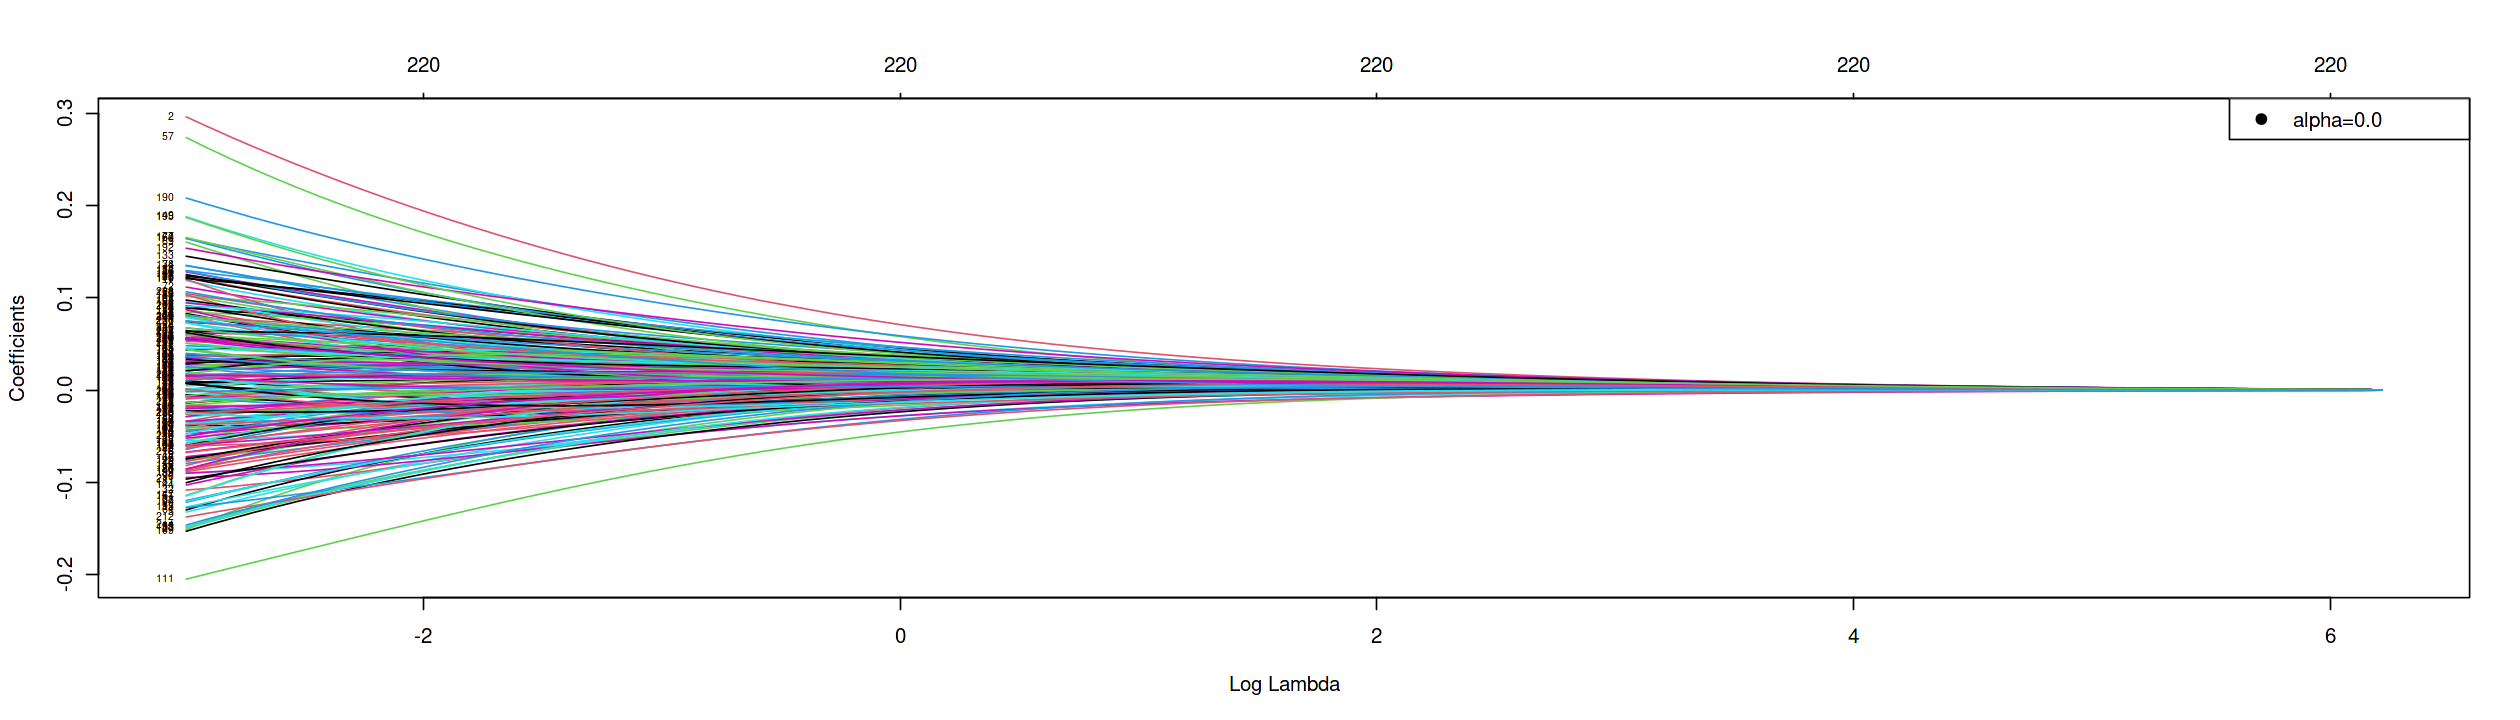

In [25]:
# alpha=0 Ridge
fit.r <- glmnet(x_train, y_train,alpha=0,standardize=FALSE, family = "binomial",lable=True)

# Looking in to lambads
plot(fit.r, xvar = "lambda", label = TRUE)
legend("topright", legend = c("alpha=0.0"), pch = 19)

# Finding best Lambda based on crossvalidation
print(cvridge)

In [26]:
# Ridge with lambda.min
m3.min <- glmnet(x_train, y_train, alpha = 0, standardize=FALSE ,family = "binomial",lambda = cvridge$lambda.min)
predict.m3.min<-predict(m3.min, newx = x_test, type = "class", s =cvridge$lambda.min)

table(predict.m3.min, y_test)

              y_test
predict.m3.min  -1   1
            -1  95   5
            1    4 102

In [27]:
cat("ACCURACY HONEST", 102*100/107,"%\n")
cat("ACCURACY DISHONEST", 99*100/99,"%\n")
cat("TOTAL ACCURACY", (102+99)*100/(206))

ACCURACY HONEST 95.3271 %
ACCURACY DISHONEST 100 %
TOTAL ACCURACY 97.57282

In [28]:
# Ridge with lambda.1se
m3.min <- glmnet(x_train, y_train, alpha = 0, standardize=FALSE ,family = "binomial",lambda = cvridge$lambda.1se)
predict.m3.min<-predict(m3.min, newx = x_test, type = "class", s =cvridge$lambda.1se)

table(predict.m3.min, y_test)

              y_test
predict.m3.min  -1   1
            -1  95   4
            1    4 103

In [29]:
cat("ACCURACY HONEST", 103*100/107,"%\n")
cat("ACCURACY DISHONEST", 95*100/99,"%\n")
cat("TOTAL ACCURACY", (102+96)*100/(206))

ACCURACY HONEST 96.26168 %
ACCURACY DISHONEST 95.9596 %
TOTAL ACCURACY 96.1165

Generally, the purpose of regularization is to balance accuracy and simplicity. This means a model with the smallest number of predictors that also gives  good accuracy. To this, the function cv.glmnet() also finds the value of lambda that gives the simplest model but also lies within one standard error of the optimal value of lambda. So we also considered the models with  one standard error lambda. We summarized the results in the following table.

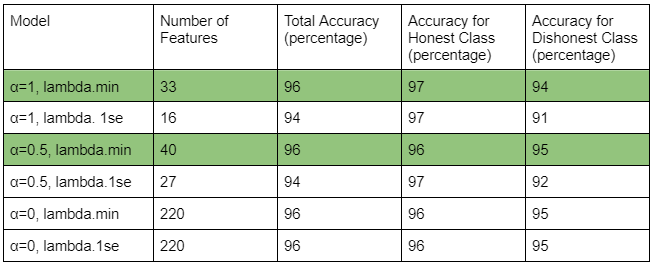

As it can be seen, in general, the penalized logistic regression is representing a good result, considering both accuracy and simplicity of the models we can say the first and third models are working better than the other ones. For the third model, we need 40 questions and for the first model, we just need 33 questions to predict if the case is an honest one or a dishonest one. We also specified the list of important questions in these models which can be found in the code.

## 3.2 Sparse SVM

The traditional soft-margin linear SVM is sparse in the observation and its hinge loss penalizes the negative margins that represent incorrect classifications. To include the sparsity also in the features, the sparse SVM is used. Its formula is:

\begin{equation}
\label{eq:penlogreg}
 \underset{\beta_{0}, \beta}{\min} \ \bigg\{ \frac{1}{n} \sum_{i=1}^{N} [1-y_{i}f(x_{i}; \beta_{0}, \beta)]_{+} + \lambda \Vert \beta \Vert_{1} \bigg\}
\end{equation}

Basically, we compute the R function sparseSVM against the lambda sequence and we highlight the minimum value of lambda with a dashed red line (in this case we obtain 0.034). 

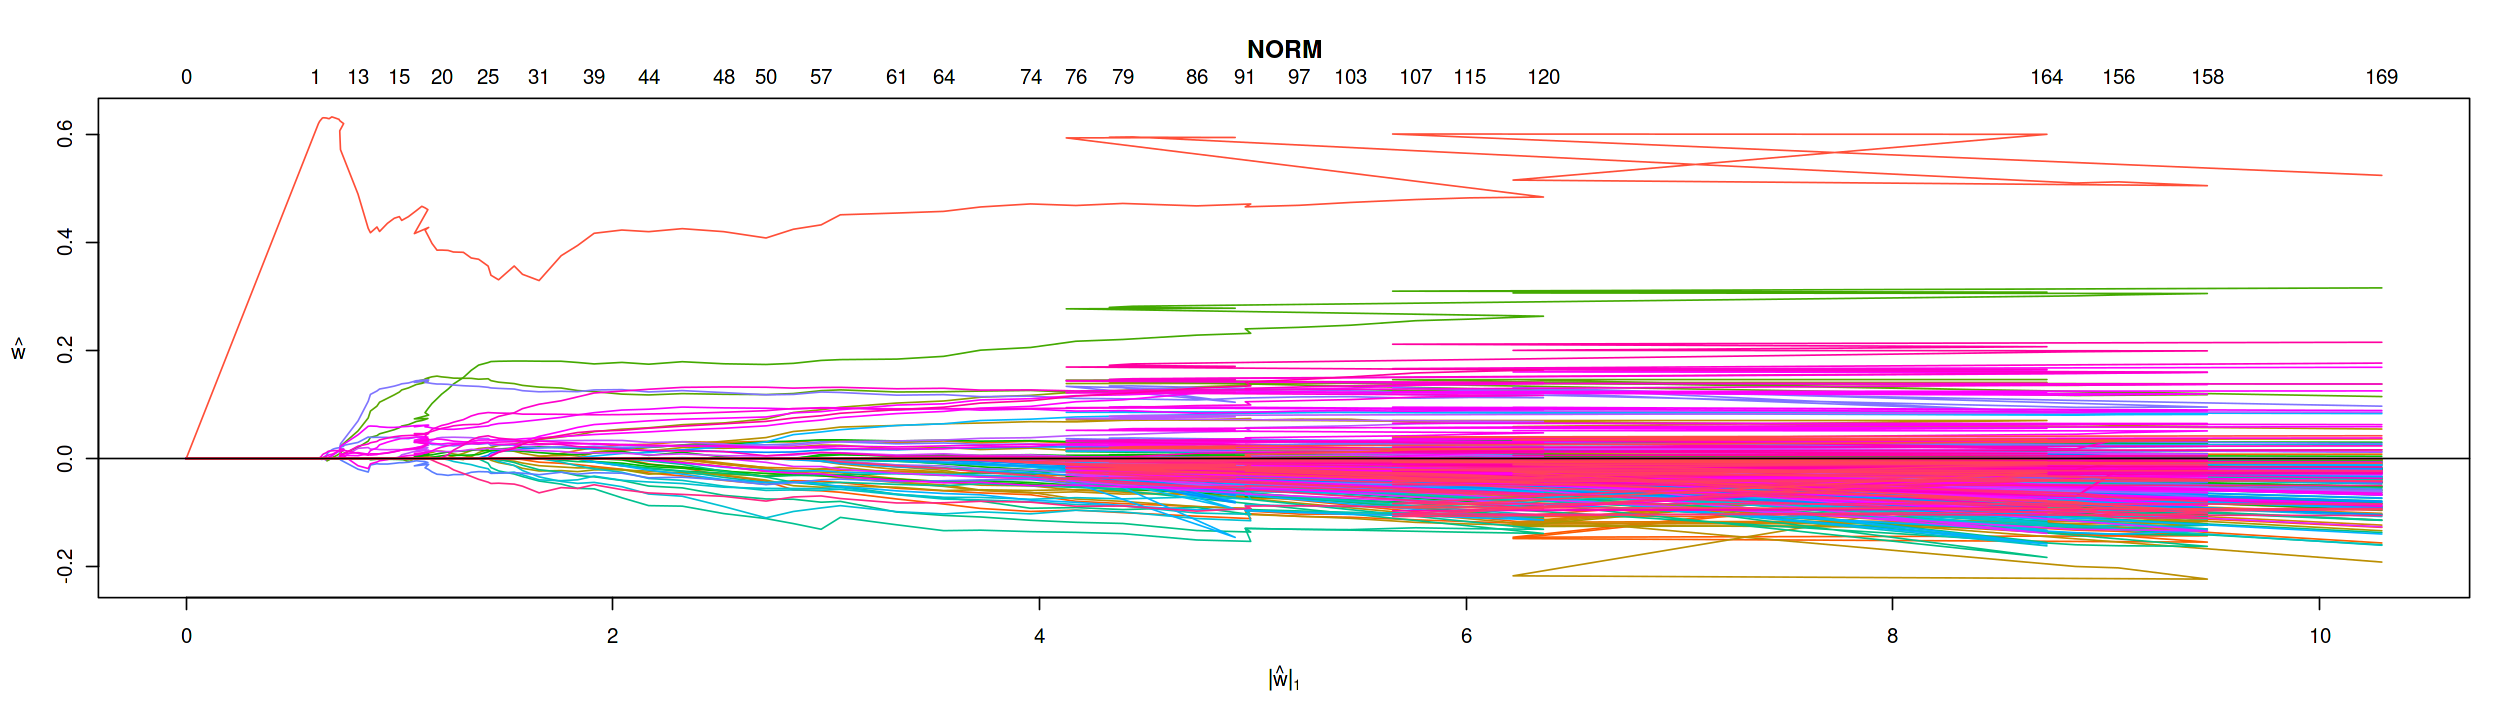

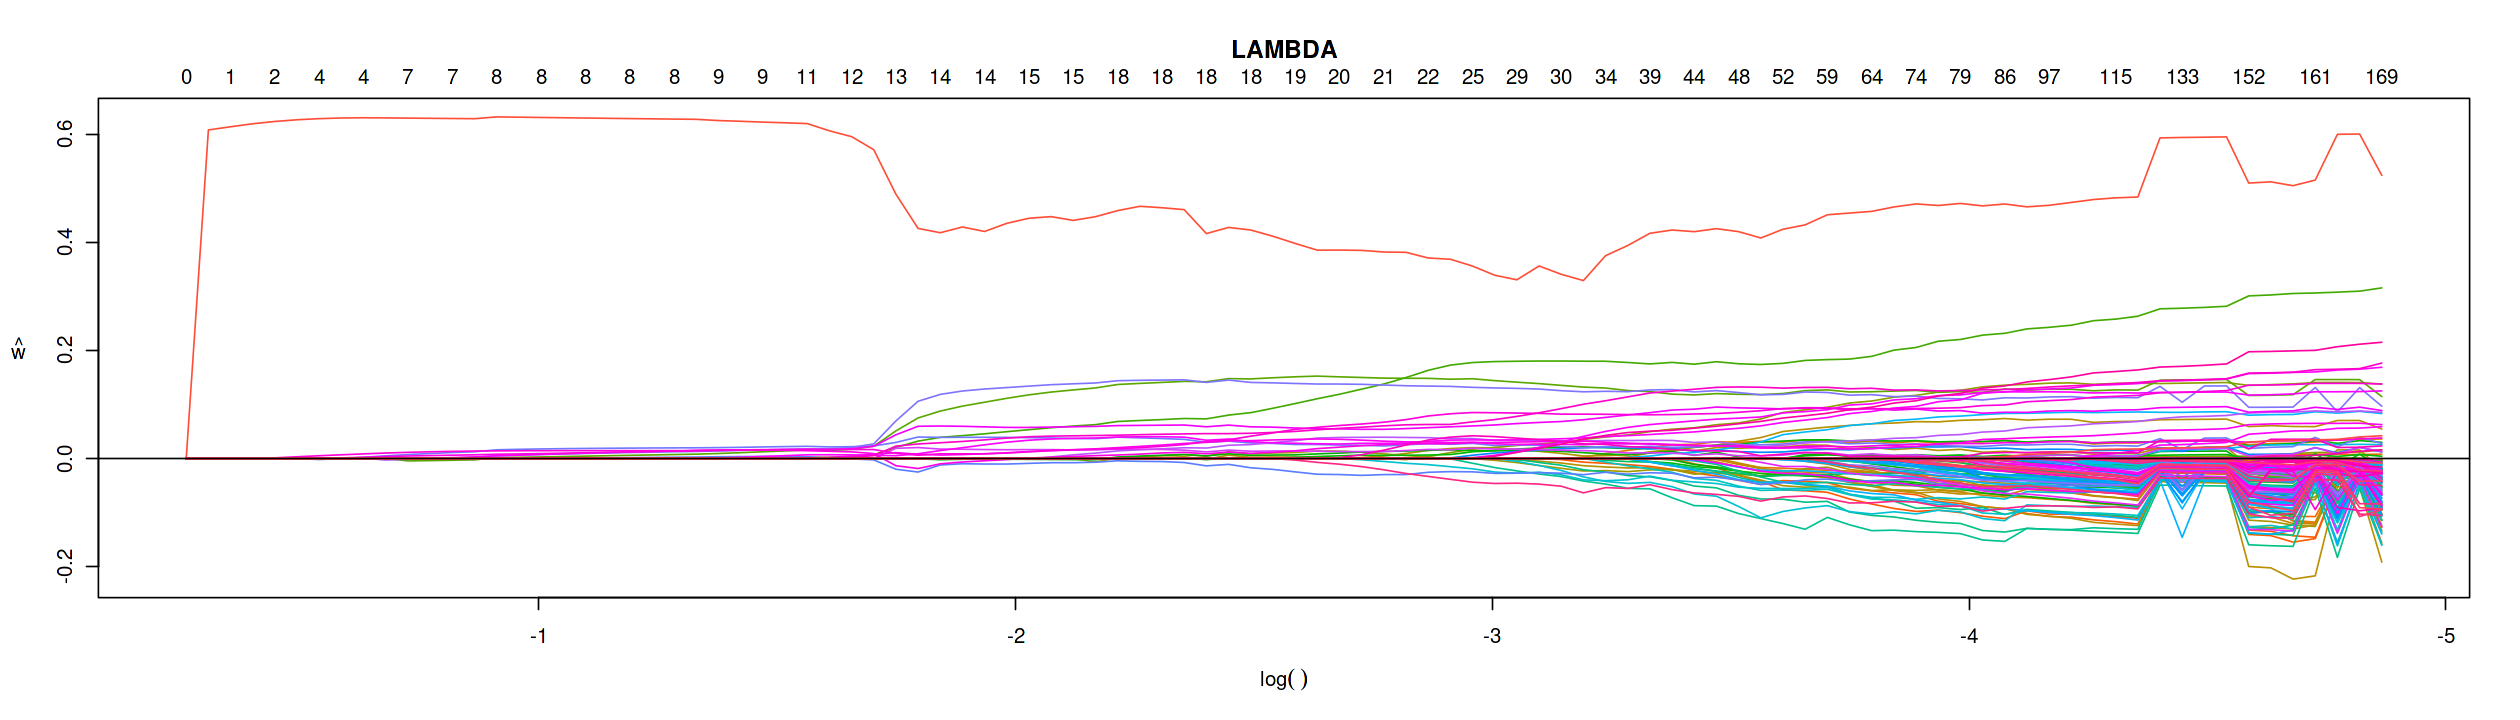

In [30]:
lasso.svm <- sparseSVM(x_train, y_train)

# xvar: What is on the X-axis. "lambda" plots against the lambda sequence, "norm" against the L1-norm of the coefficients.
plot(lasso.svm, xvar="norm", main="NORM")
plot(lasso.svm, xvar="lambda", main="LAMBDA")

After we compute the cross-validation on the model because this method helps us to assess how the results of a statistical analysis will generalize to an independent data set.

MINIMUM of LAMBDA:  0.02970631

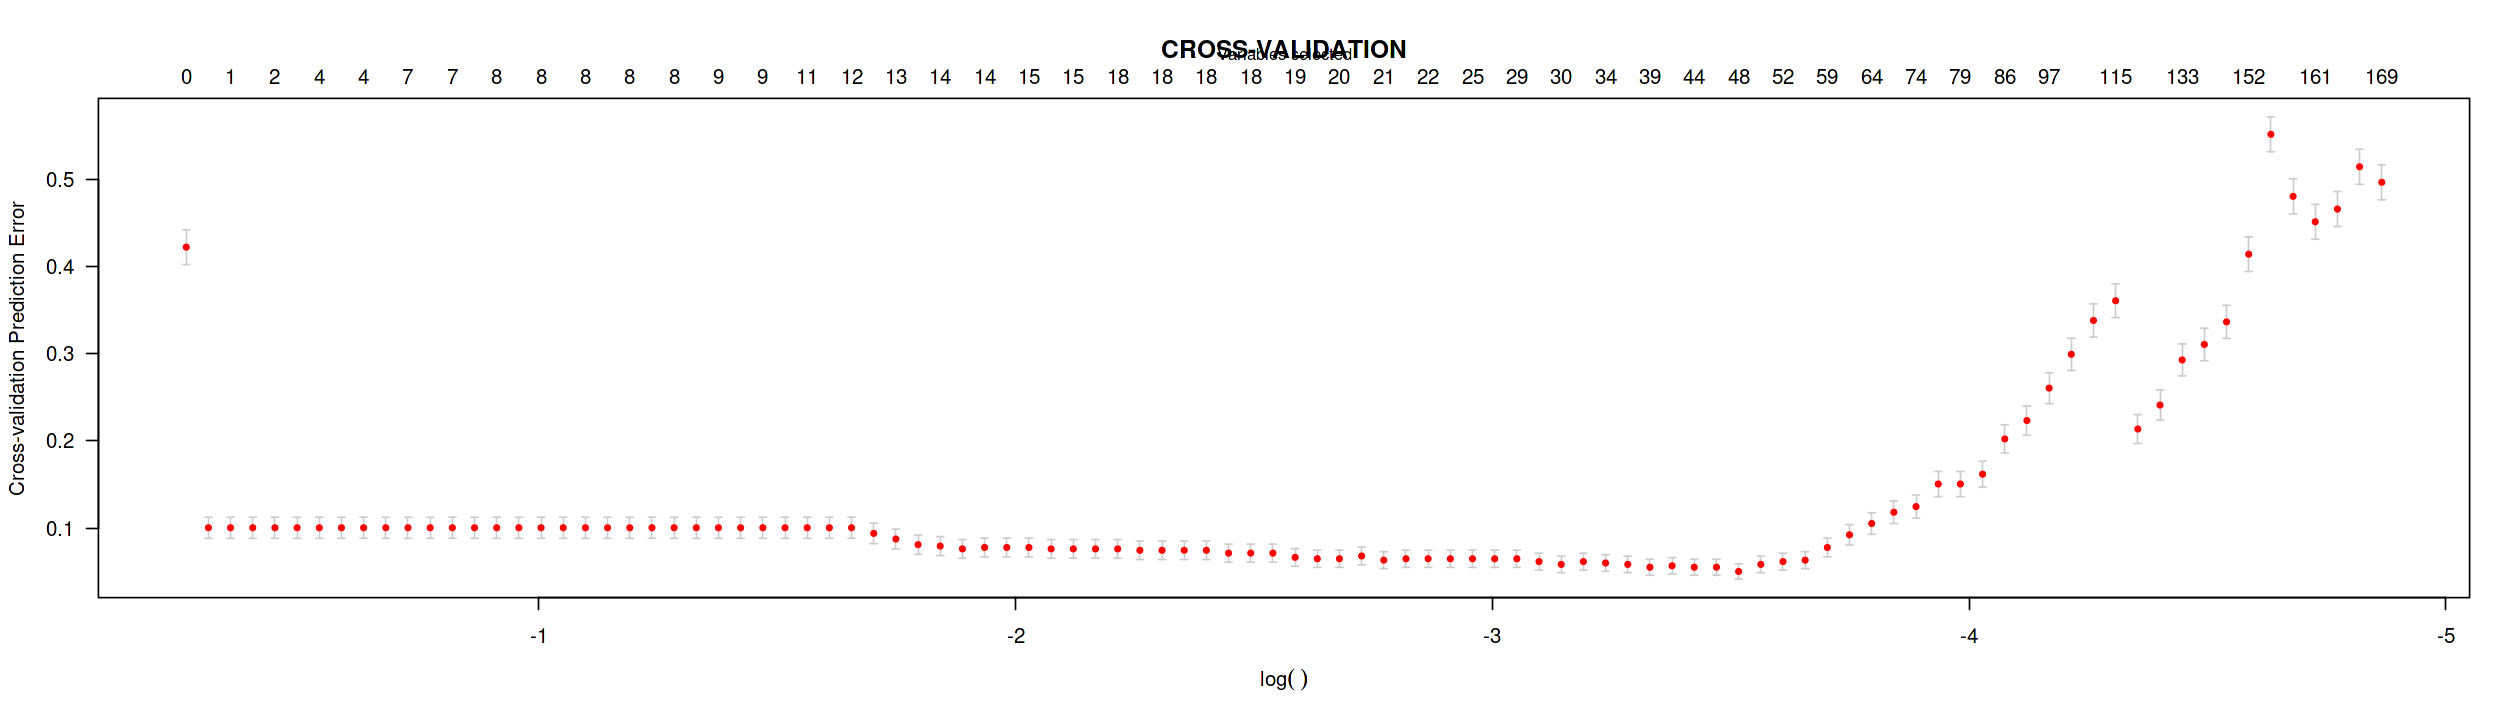

In [31]:
#cv.sparseSVM: Perform k-fold cross validation for sparse linear SVM regularized by lasso or elastic-net over a sequence of lambda values and find an optimal lambda.
cv.svm <- cv.sparseSVM(x_train, y_train)
cat("MINIMUM of LAMBDA: ", cv.svm$lambda.min)
plot(cv.svm, main="CROSS-VALIDATION")

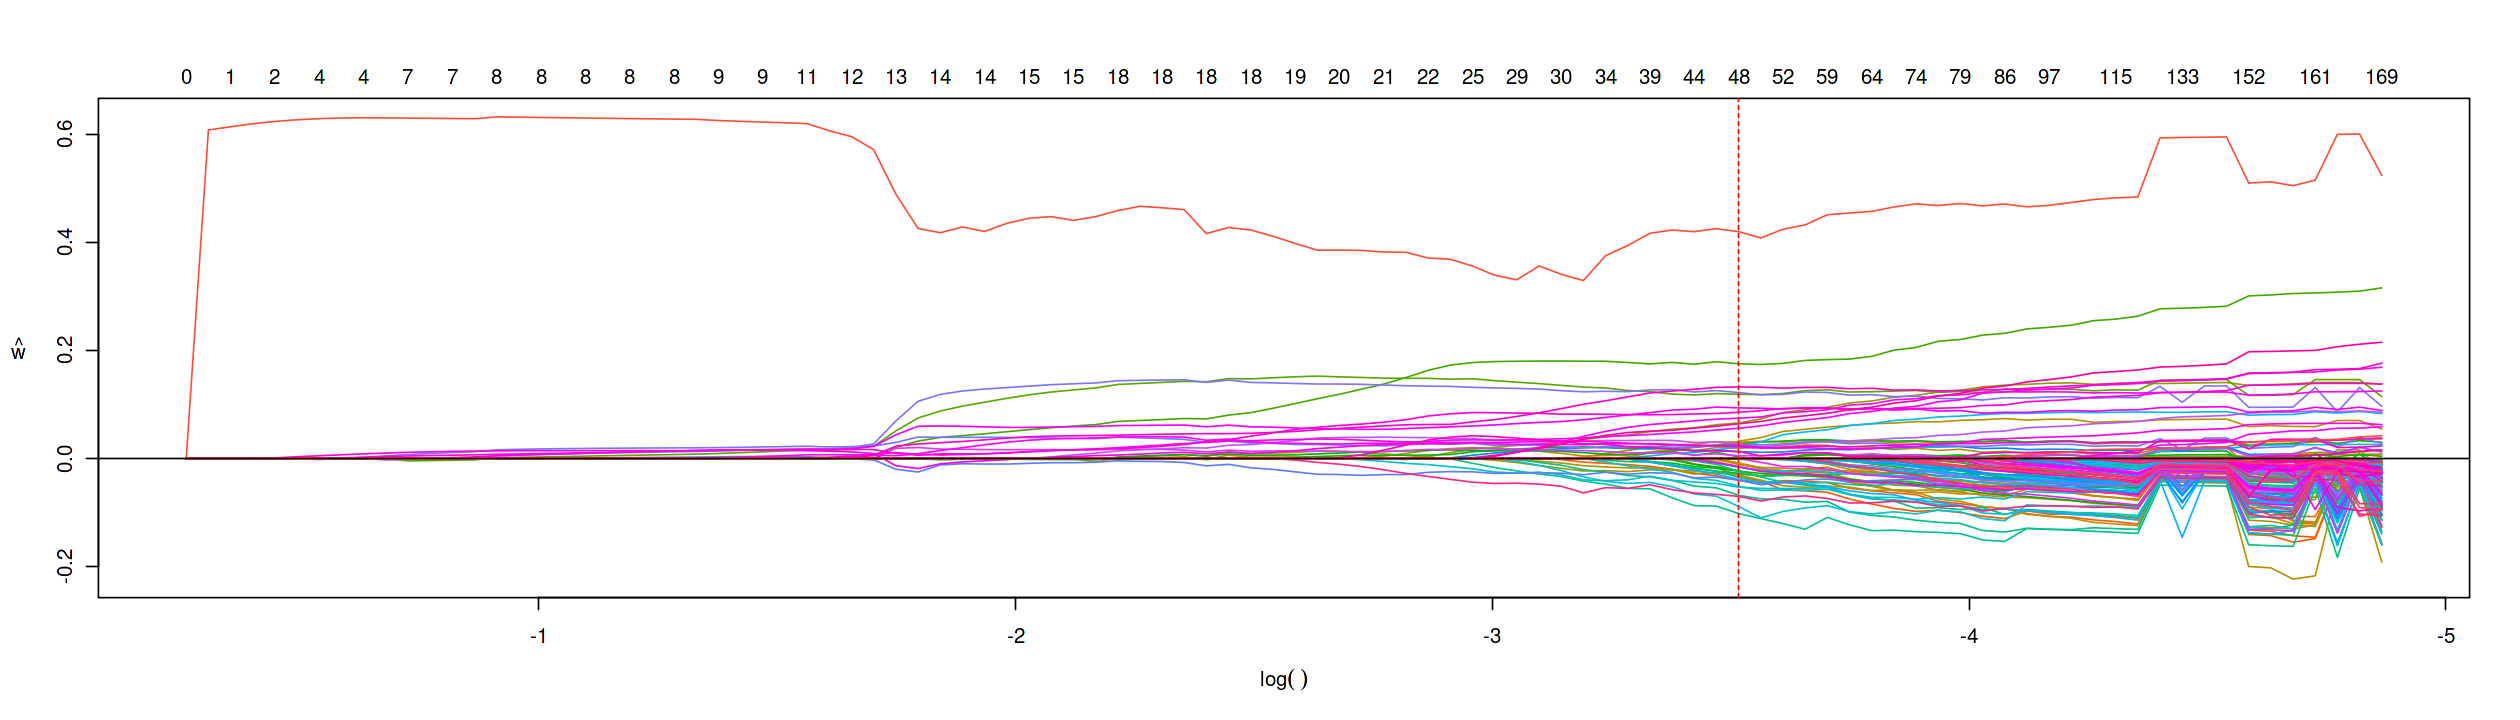

In [32]:
# Add the minimum of lambda to plot of lasso.svm
plot(lasso.svm)
abline(v = log(cv.svm$lambda.min), col = "red", lty = "dashed", main="LAMBDA")

-0.5634886 0.4197653 -0.0315938 -0.04035487 -0.01057538 0.03002566 -0.0106108 -0.008139088 -0.01491408 0.03202925 -0.03069462 0.01898888 -0.0290822 0.06591075 0.118863 0.1753281 -0.02245208 0.002918652 0.02659889 -0.02345353 -0.02701033 -0.02366065 -0.06808839 -0.1017811 -0.03483526 -0.05103627 -0.05297314 -0.08868641 -0.0003097938 0.02185147 -0.01606261 -0.03892199 0.01288525 -0.03971766 0.02471019 0.1220761 0.0266647 0.005242631 0.0937652 -0.01501797 0.07471807 0.05598997 0.02172214 0.02389833 0.08564856 0.1324789 0.01292002 0.06429808 -0.06993551

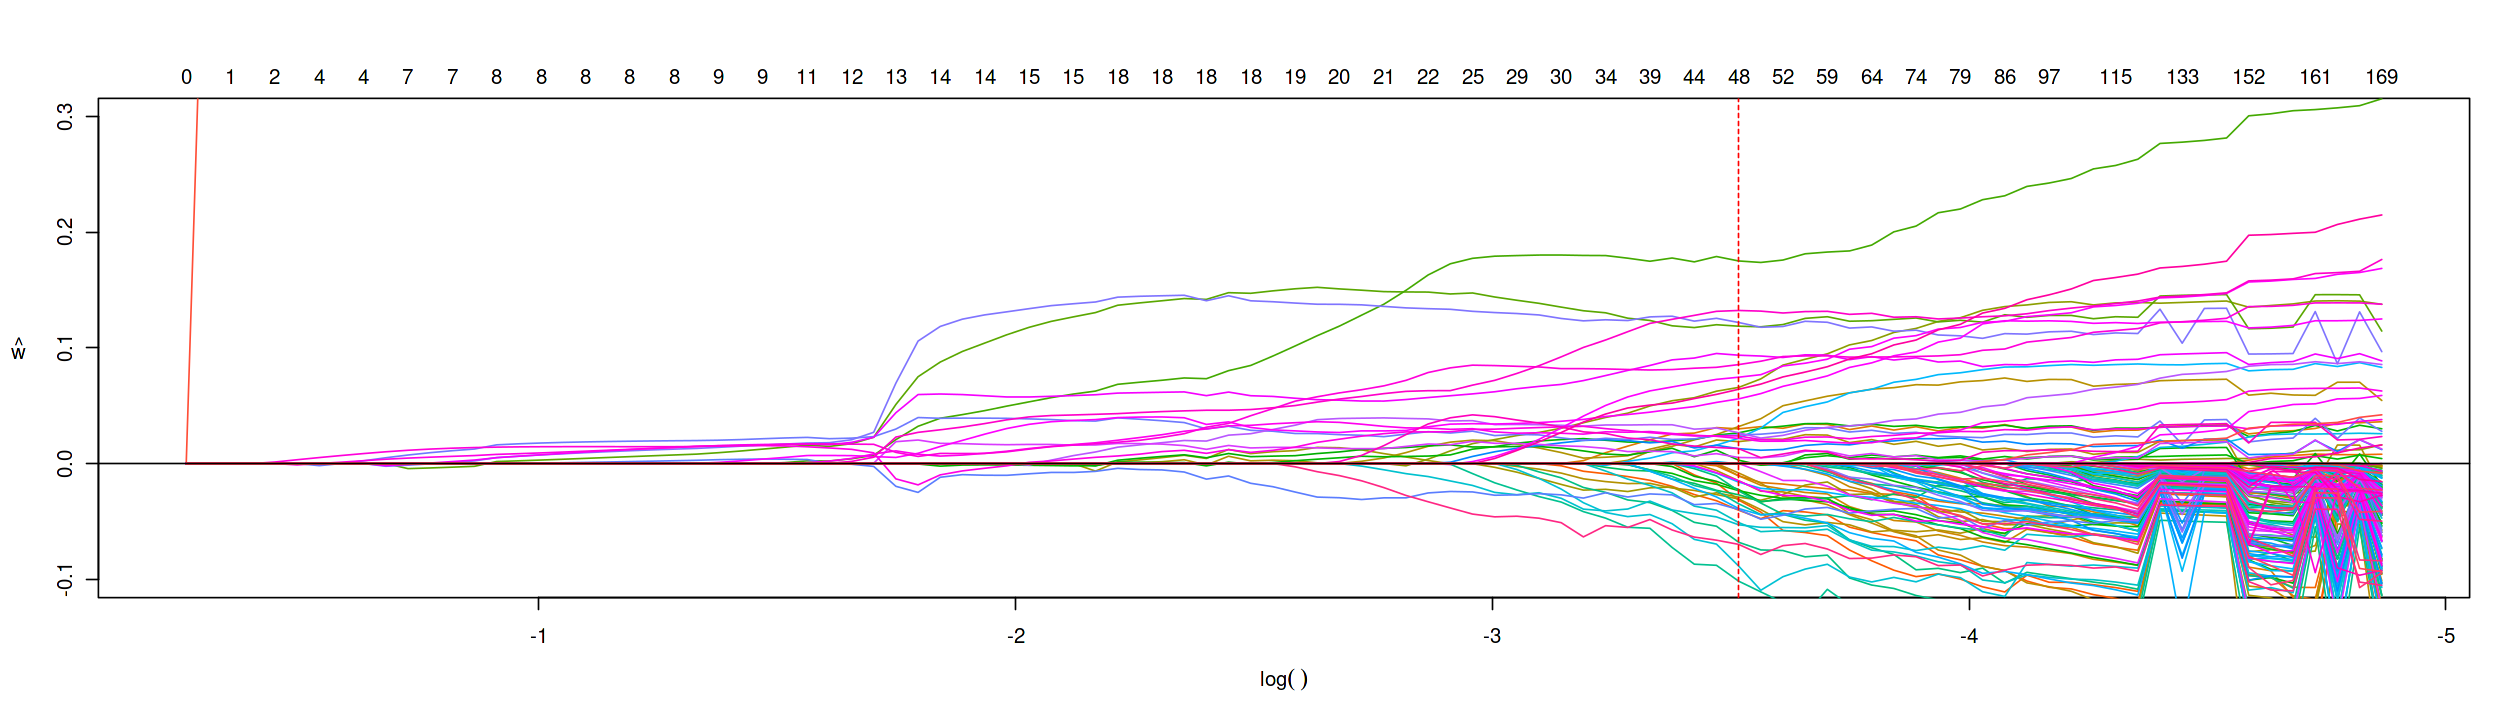

In [33]:
#zoom the part around the choice of lambda
plot(lasso.svm, ylim=c(-0.1,0.3))
abline(v = log(cv.svm$lambda.min), col = "red", lty = "dashed", main="LAMBDA")

#coefficient with minimum lambda
cat(coef(lasso.svm)[, cv.svm$lambda == cv.svm$lambda.min][coef(lasso.svm)[, cv.svm$lambda == cv.svm$lambda.min]!=0])

In [34]:
coefs <- coef(cv.svm, s=cv.svm$lambda.min)
coefs_no_zero <- coefs[which(coefs!=0)]
length(coefs_no_zero)

[1] 49

In [35]:
y_pred <- predict(lasso.svm, x_test, lambda = cv.svm$lambda.min)
table(y_pred, y_test)

      y_test
y_pred -1  1
    -1 95  9
    1   4 98

In [36]:
cat("ACCURACY HONEST", 101*100/103,"%\n")
cat("ACCURACY DISHONEST", 95*100/103,"%\n")
cat("TOTAL ACCURACY", (101+95)*100/(206))

ACCURACY HONEST 98.05825 %
ACCURACY DISHONEST 92.23301 %
TOTAL ACCURACY 95.14563

## 3.3 Sparse PCA

The sparse PCA attempts to find sparse weight vectors (loadings), i.e., a weight vector with only a few ’active’ (nonzero) values. This approach leads to an improved interpretability of the model, because the principal components are formed as a linear combination of only a few of the original variables. Further, SPCA avoids overfitting in a high-dimensional data setting where the number of variables p is greater than the number of observations n.
Initially, we run the R function spca with 10 components to be computed.

In [37]:
fit <- spca(x_train, k=10, verbose=F)
summary(fit)

PC1     PC2    PC3    PC4   PC5   PC6   PC7   PC8  
Explained variance     121.297 18.962 11.073 8.733 5.842 4.267 3.957 3.187
Standard deviations     11.013  4.355  3.328 2.955 2.417 2.066 1.989 1.785
Proportion of variance   0.407  0.064  0.037 0.029 0.020 0.014 0.013 0.011
Cumulative proportion    0.407  0.470  0.508 0.537 0.557 0.571 0.584 0.595
                       PC9   PC10 
Explained variance     2.953 2.555
Standard deviations    1.718 1.598
Proportion of variance 0.010 0.009
Cumulative proportion  0.605 0.613

REG.PAR
[1]   0.0000 133.4808
[1]   0.0050 110.9174
[1]  0.01000 91.41997
[1]  0.01500 77.67655
[1]  0.0200 68.1399
[1]  0.0250 60.3072
[1]  0.03000 54.27662
[1]  0.03500 49.58807
[1]  0.0400 44.9142
[1]  0.04500 40.26963
[1]  0.05000 35.67549
[1]  0.05500 31.10857
[1]  0.06000 26.61657
[1]  0.06500 22.14034
[1]  0.07000 17.65653
[1]  0.07500 13.25307
[1] 0.08 0.00
[1] 0.085 0.000
[1] 0.09 0.00
[1] 0.095 0.000


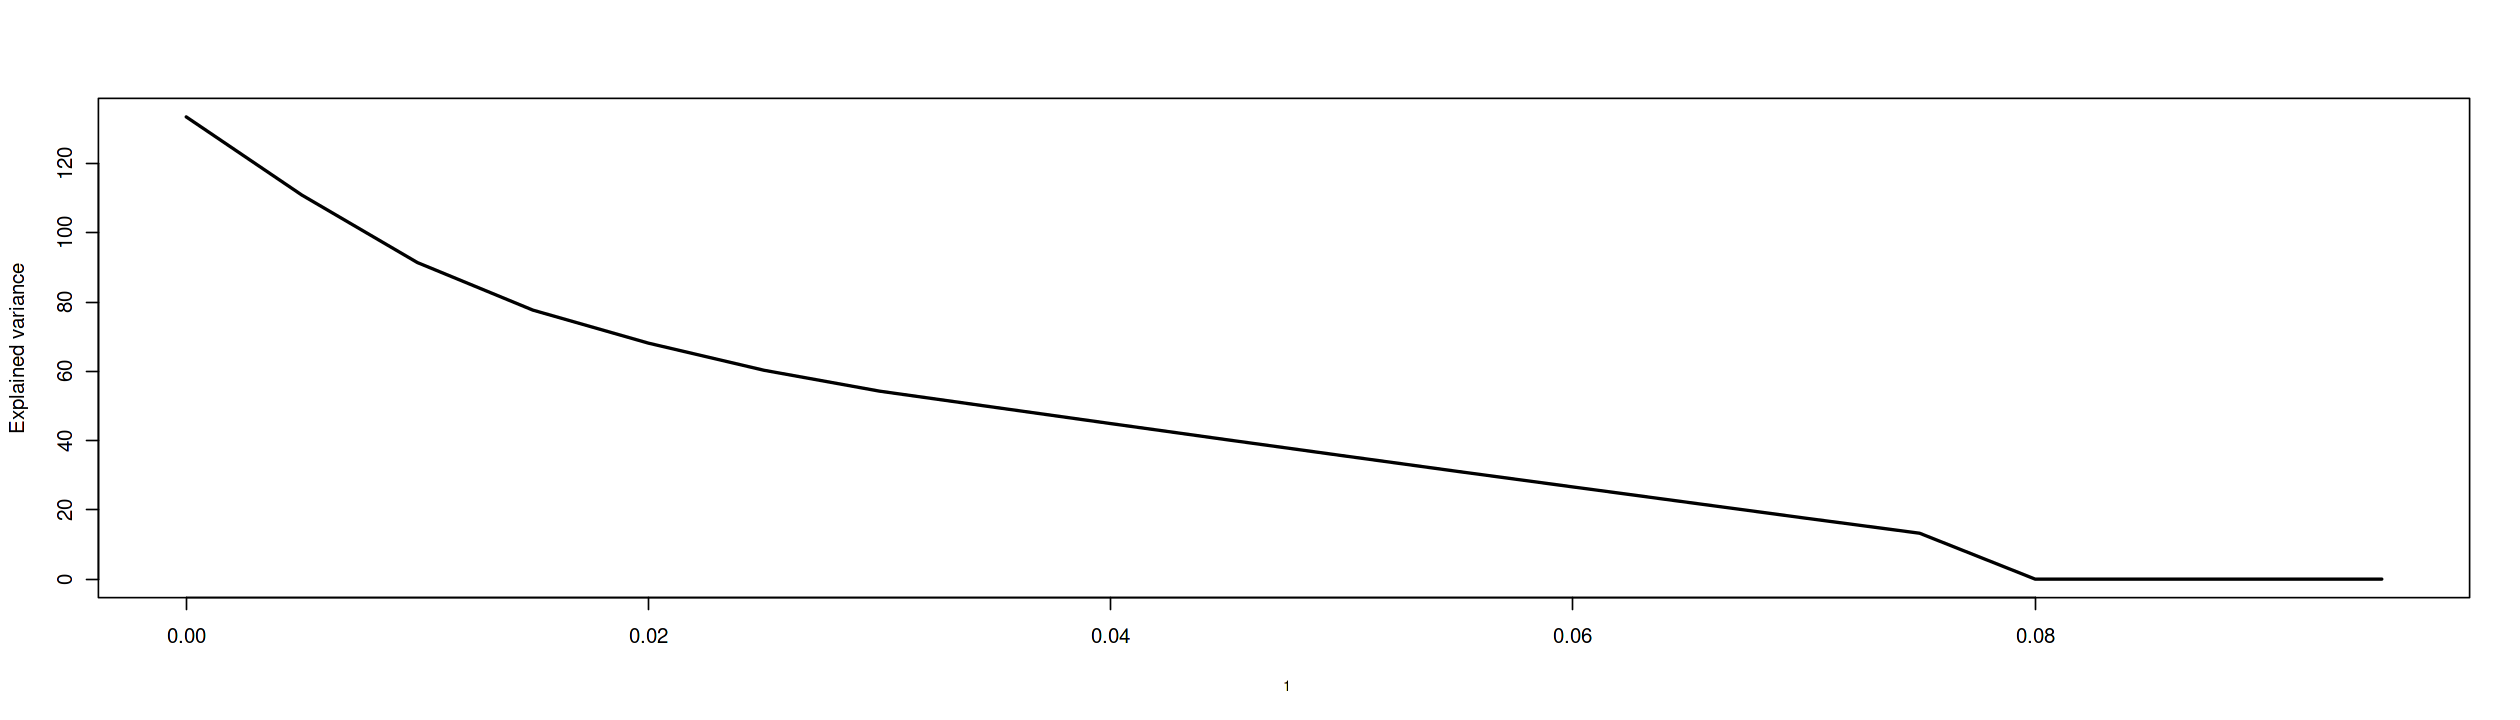

In [38]:
# Regularization of parameters
cat("REG.PAR\n")
var.sp<- NULL
reg.par<- seq(0,0.095, length=20)
j<-1
for(i in reg.par){
    fit <- spca(x_train, k=10, alpha= i,  scale=TRUE, verbose=F)
    var.sp[j]<-sum(fit$sdev^2)
    print(c(i, sum(fit$sdev^2)))	
    j<-j+1
}

plot(reg.par, var.sp, type="l", xlab = expression(lambda[1]), ylab="Explained variance", lwd=2)

In [39]:
# Variance not yet explained
1-var.sp/var.sp[1]
diff(1-var.sp/var.sp[1])

[1] 0.0000000 0.1690391 0.3151079 0.4180697 0.4895155 0.5481958 0.5933752
 [8] 0.6285005 0.6635158 0.6983115 0.7327295 0.7669435 0.8005963 0.8341309
[15] 0.8677223 0.9007118 1.0000000 1.0000000 1.0000000 1.0000000

[1] 0.16903907 0.14606879 0.10296179 0.07144586 0.05868026 0.04517939
 [7] 0.03512533 0.03501528 0.03479576 0.03441799 0.03421404 0.03365278
[13] 0.03353461 0.03359141 0.03298950 0.09928816 0.00000000 0.00000000
[19] 0.00000000

In [40]:
# Which parameter? 
set_alpha = reg.par[4]
cat(set_alpha)

0.015

In [41]:
#select 4 components
fit <- spca(x_train, k=4, alpha= set_alpha, scale=TRUE, verbose=F)

# Print non-zero loadings
V <- fit$loadings
cat("\nNon-zero loadings\n")
for (j in 1:ncol(V)) {
  ind <- which(V[,j] != 0)
  v <- V[ind,j]
  names(v) <- colnames(x)[ind]
  print(v)
}

fit <- spca(scale(x), k=4, alpha= reg.par[5],  scale=TRUE, verbose=F)
summary(fit)


Non-zero loadings
          Q2          Q11          Q16          Q17          Q19          Q22 
-0.211729971 -0.156083489 -0.090741775 -0.138089018 -0.123004750 -0.057119479 
         Q24          Q25          Q26          Q31          Q33          Q36 
-0.063304869 -0.095029421 -0.076304068 -0.047763175 -0.003916429 -0.201802341 
         Q37          Q39          Q41          Q42          Q44          Q48 
-0.189853299 -0.098980833 -0.123901398 -0.109588491 -0.114413711 -0.134891917 
         Q52          Q53          Q54          Q55          Q70          Q71 
-0.254523620 -0.092343901 -0.218057341 -0.226241718 -0.057688707 -0.190956892 
         Q72          Q76          Q83         Q106         Q108         Q114 
-0.222988691 -0.023431194 -0.025580709 -0.133176862 -0.040194935 -0.114230887 
        Q116         Q125         Q133         Q134         Q136         Q138 
-0.082369687 -0.032682843 -0.187969198 -0.128516246 -0.075384126 -0.063596440 
        Q139         Q143        

PC1    PC2   PC3   PC4  
Explained variance     65.424 2.672 0.535 0.140
Standard deviations     8.089 1.635 0.732 0.374
Proportion of variance  0.297 0.012 0.002 0.001
Cumulative proportion   0.297 0.310 0.312 0.313

We analyzed the amount of variance not yet explained by each group because we want to choose an optimal alpha parameter for regularizing the model. While the parameter is chosen, we compute the spca with the new alpha and with 4 components. We captured only the values with non-zero loadings to find the most important questions, and we obtained 81 questions.
At the end, we did a simple linear regression to show how good the model with the new variables fit.

In [42]:
V<- fit$loadings

# Regress on principal components
pcData <- as.data.frame(scale(x_train) %*% V) # length col 824
log_reg <- glm(as.numeric(y_train) ~ ., family=gaussian, data=pcData)
summary(log_reg)


Call:
glm(formula = as.numeric(y_train) ~ ., family = gaussian, data = pcData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4155  -0.3071  -0.1198   0.1708   2.1967  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.012945   0.022198  -0.583   0.5600    
V1           0.122816   0.003522  34.871  < 2e-16 ***
V2          -0.039464   0.026396  -1.495   0.1354    
V3          -0.397564   0.091163  -4.361 1.52e-05 ***
V4           0.567851   0.289243   1.963   0.0501 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.3045251)

    Null deviance: 617.90  on 617  degrees of freedom
Residual deviance: 186.67  on 613  degrees of freedom
AIC: 1026

Number of Fisher Scoring iterations: 2


## 3.4 Group Lasso
We didn't use Fused Lasso because "neighborhood" has no meaning in our dataset. The Group Lasso is a variant of standard Lasso introduced in Yuan & Lin, 2006 that allows for preselected groups of covariates to be jointly included or excluded from the model. This may be useful in cases of categorical factors, groups of basis functions or simply sets of variables grouped together to capture an unobservable latent variable. 

\begin{equation}
\label{eq:penlogreg}
 \underset{\beta_{0} \in \mathbb{R}, \gamma \in \mathbb{R}^{p_{j}}}{\min} \ \bigg\{ \frac{1}{2} \sum_{i=1}^{N} (y_{i}-\beta_{0}-\sum_{j=1}^{J}z_{ij}^{T} \gamma_{j})^{2} + \lambda \sum_{j=1}^{J} \Vert \gamma_{j} \Vert_{2} \bigg\}
\end{equation}

As we can see in the formula above, group lasso is an extension of the standard lasso where instead of minimizing the norm of individual coefficients we aim at minimizing the magnitude of groups of coefficients.
In the context of our dataset we know from the associated documentation that each of the 220 answers is used to evaluate one (and only one) of 25 psychological traits like depression, impulsiveness, attention-seeking behavior, hostility and so on, and therefore it would make sense to build a model considering 25 different groups of variables instead considering them individually.
The model has been built using the gglasso library in R using a misclassification loss function to perform cross validation and a logit loss function to fit the optimal model. The optimal lambda that has been found is 0.01 and corresponds to a model of 153 variables out of the initial 221, with an overall accuracy of 95\% (which remains stable across both conditions).


In [43]:
# Creation of categories (1st type)
cat1 = seq(1:220)*0
cat1[c(8,45,84,91,101,167,184)]=1                     # Affettivita ridotta
cat1[c(1,23,26,30,124,155,157,189)]=2                 # Anedonia
cat1[c(12,50,57,64,127,149,175)]=3                    # Angoscia di separazione
cat1[c(79,93,95,96,109,110,130,141,174)]=4            # Ansia
cat1[c(94,99,106,139,143,150,194,209)]=5              # Esperienze inusuali
cat1[c(27,61,66,81,86,104,119,148,151,163,
       168,169,178,212)]=6                            # Depressivita
cat1[c(36,37,42,44,59,77,83,154,192,193,213,217)]=7   # Disregolazione percettiva
cat1[c(6,29,47,68,88,118,132,144,199)]=8              # Distraibilita
cat1[c(5,21,24,25,33,52,55,70,71,152,172,185,205)]=9  # Eccentricita
cat1[c(89,97,108,120,145,203)]=10                     # Evitamento intimita
cat1[c(40,65,114,179,187,197)]=11                     # Grandiosita
cat1[c(4,16,17,22,58,204)]=12                         # Impulsivita
cat1[c(41,53,56,76,126,134,142,206,214,218)]=13       # Inganno
cat1[c(11,13,19,54,72,73,90,153,166,183,
       198,200,207,208)]=14                           # Insensibilita
cat1[c(31,129,156,160,171,201,210)]=15                # Irresponsabilita
cat1[c(18,62,102,122,138,165,181)]=16                 # Labilita emotiva
cat1[c(107,125,162,180,219)]=17                       # Manipolatorieta
cat1[c(28,32,38,85,92,116,158,170,188,216)]=18        # Ostilita
cat1[c(34,49,105,115,123,135,140,176,196,220)]=19     # Perfezionismo rigido
cat1[c(46,51,60,78,80,100,121,128,137)]=20            # Perseverazione
cat1[c(14,43,74,111,113,173,191,211)]=21              # Ricerca di attenzione
cat1[c(10,20,75,82,136,146,147,161,182,186)]=22       # Ritiro
cat1[c(2,103,117,131,133,177,190)]=23                 # Sospettosita
cat1[c(9,15,63,202)]=24                               # Sottomissione
cat1[c(3,7,35,39,48,67,69,87,98,112,159,164,195,215)]=25 # Correre rischi

List of 9
 $ b0     : Named num [1:100] -0.0259 -0.1738 -0.3126 -0.4437 -0.5682 ...
  ..- attr(*, "names")= chr [1:100] "s0" "s1" "s2" "s3" ...
 $ beta   : num [1:220, 1:100] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:220] "Q1" "Q2" "Q3" "Q4" ...
  .. ..$ : chr [1:100] "s0" "s1" "s2" "s3" ...
 $ df     : Named int [1:100] 0 10 10 10 10 10 14 14 14 24 ...
  ..- attr(*, "names")= chr [1:100] "s0" "s1" "s2" "s3" ...
 $ dim    : int [1:2] 220 100
 $ lambda : num [1:100] 0.37 0.345 0.322 0.3 0.28 ...
 $ npasses: int 63901
 $ jerr   : int 0
 $ group  : int [1:220] 2 23 25 12 9 8 25 1 24 22 ...
 $ call   : language gglasso(x = x_train, y = y_train, group = cat1, loss = "logit")
 - attr(*, "class")= chr [1:2] "gglasso" "logit"


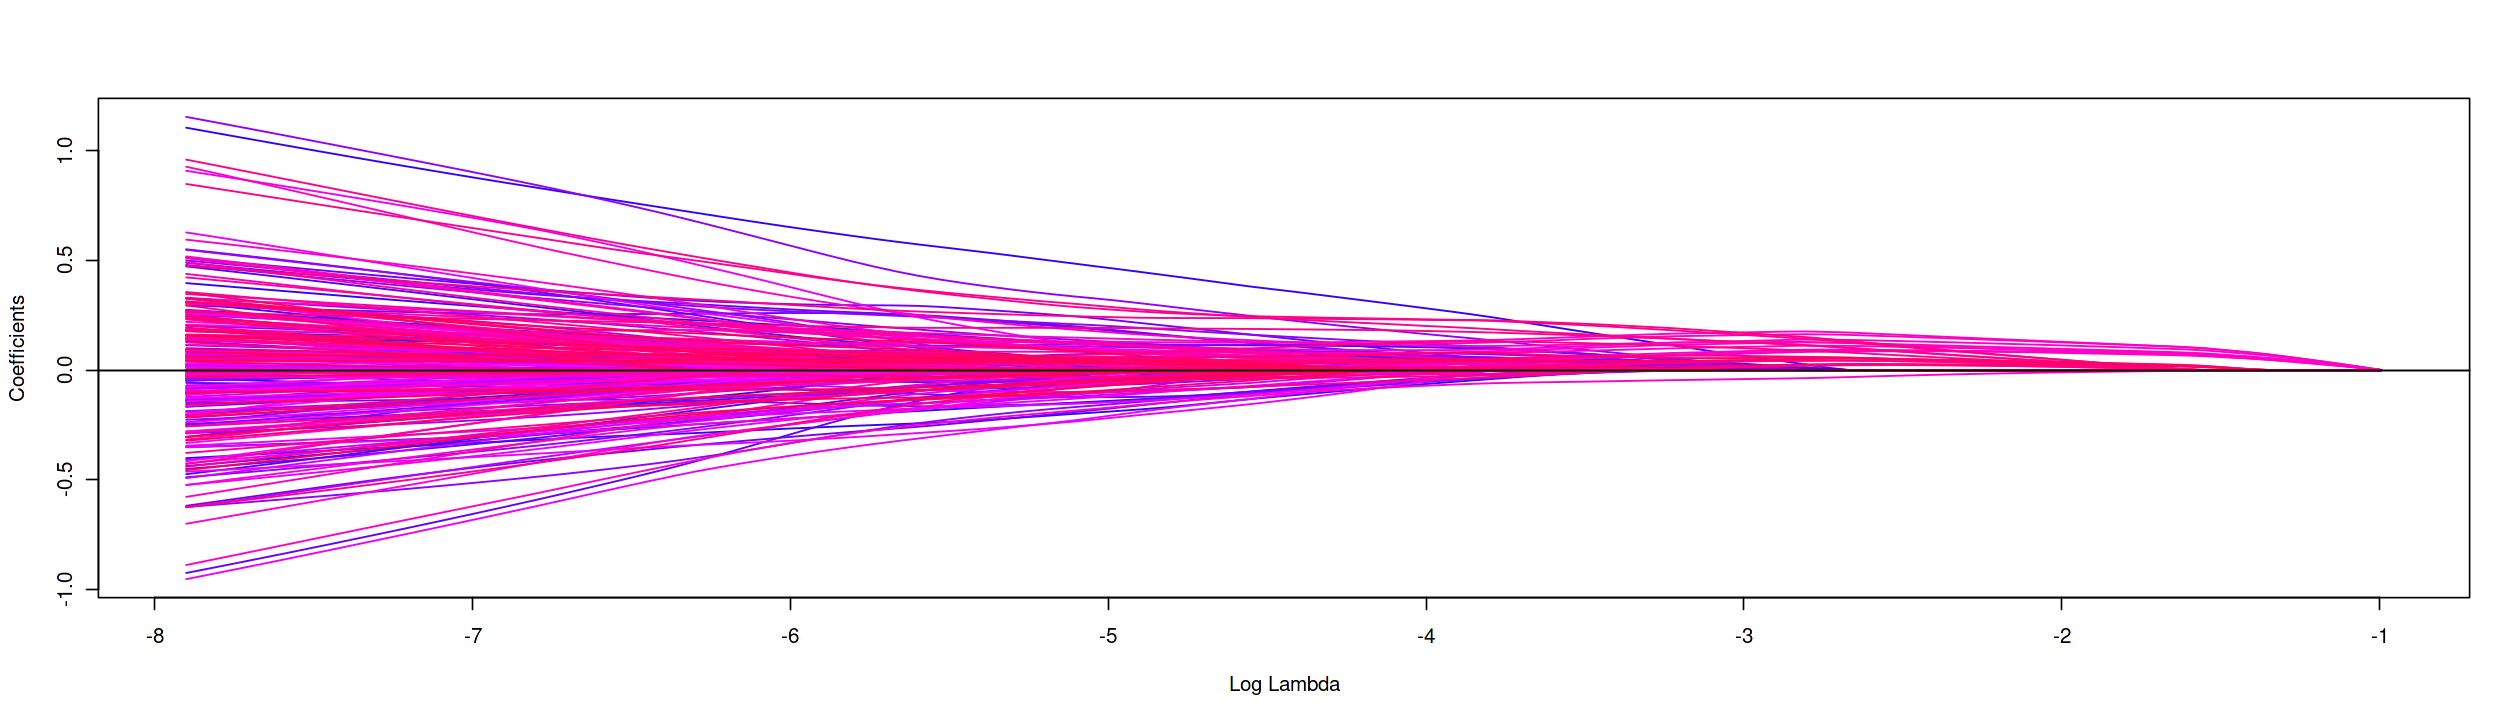

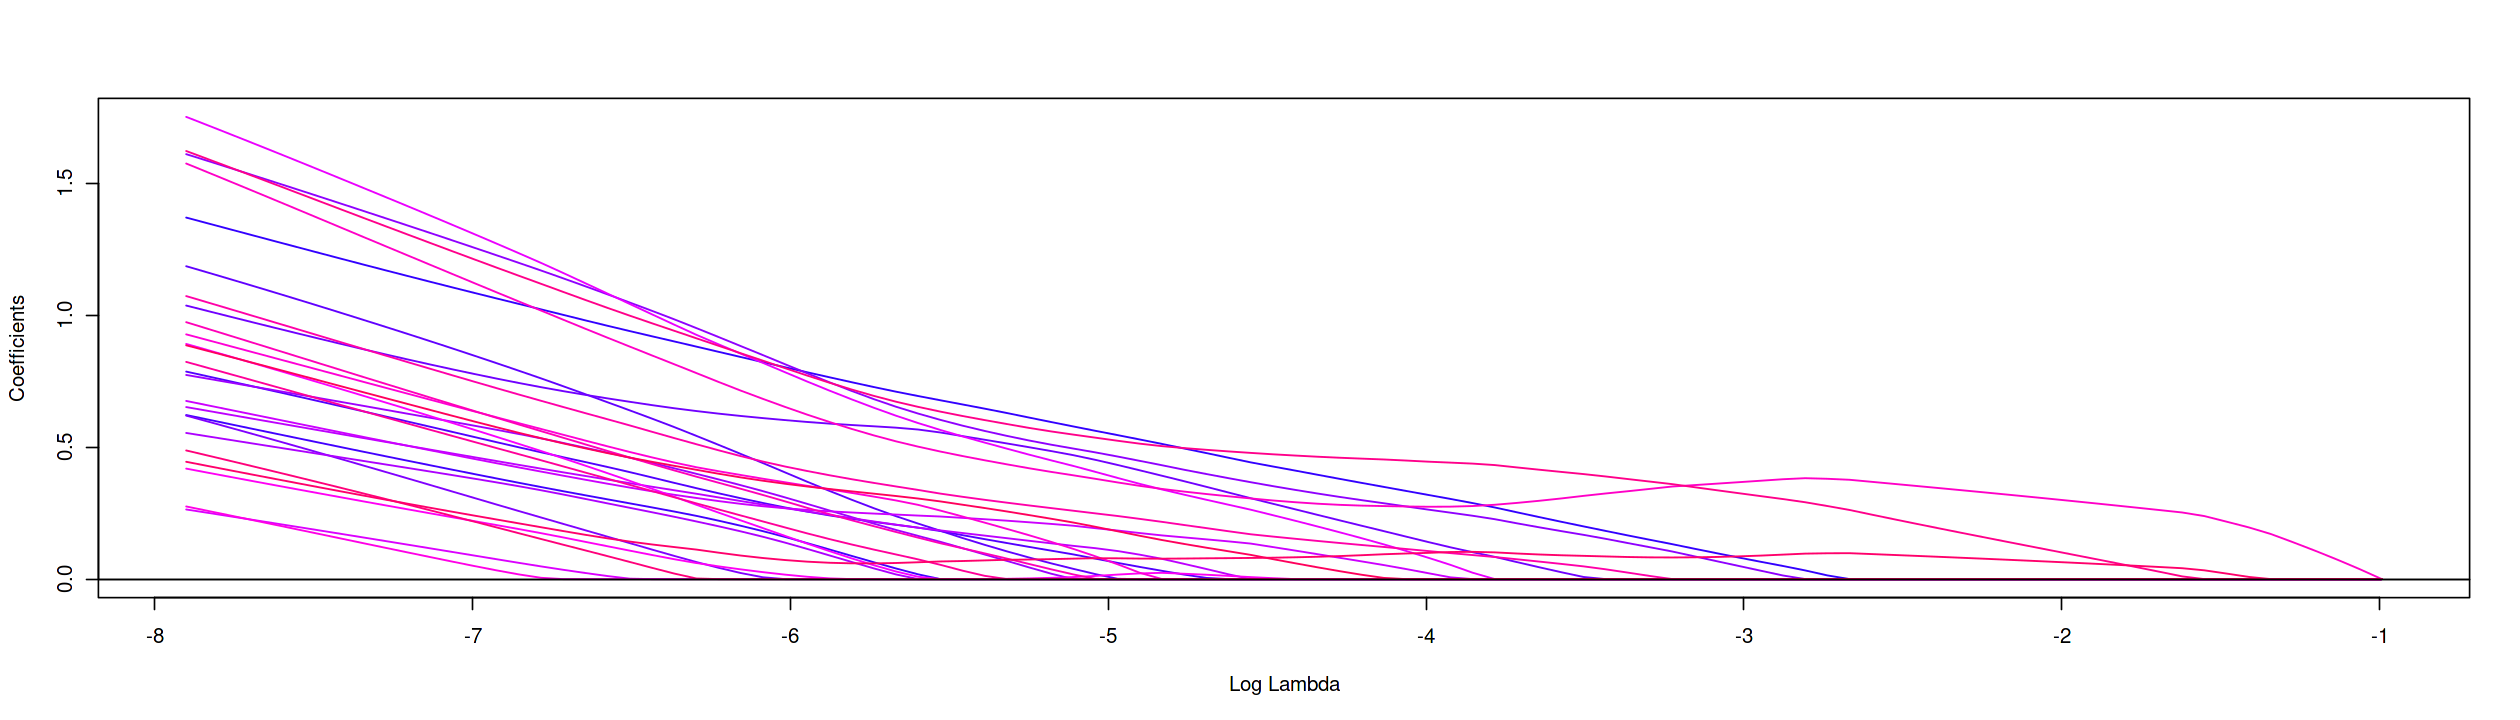

In [44]:
# Group lasso model
fitgg = gglasso(x_train, y_train, group=cat1, loss='logit')
str(fitgg)
coef.matgg=fitgg$beta
plot(fitgg)
plot(fitgg, group=TRUE)

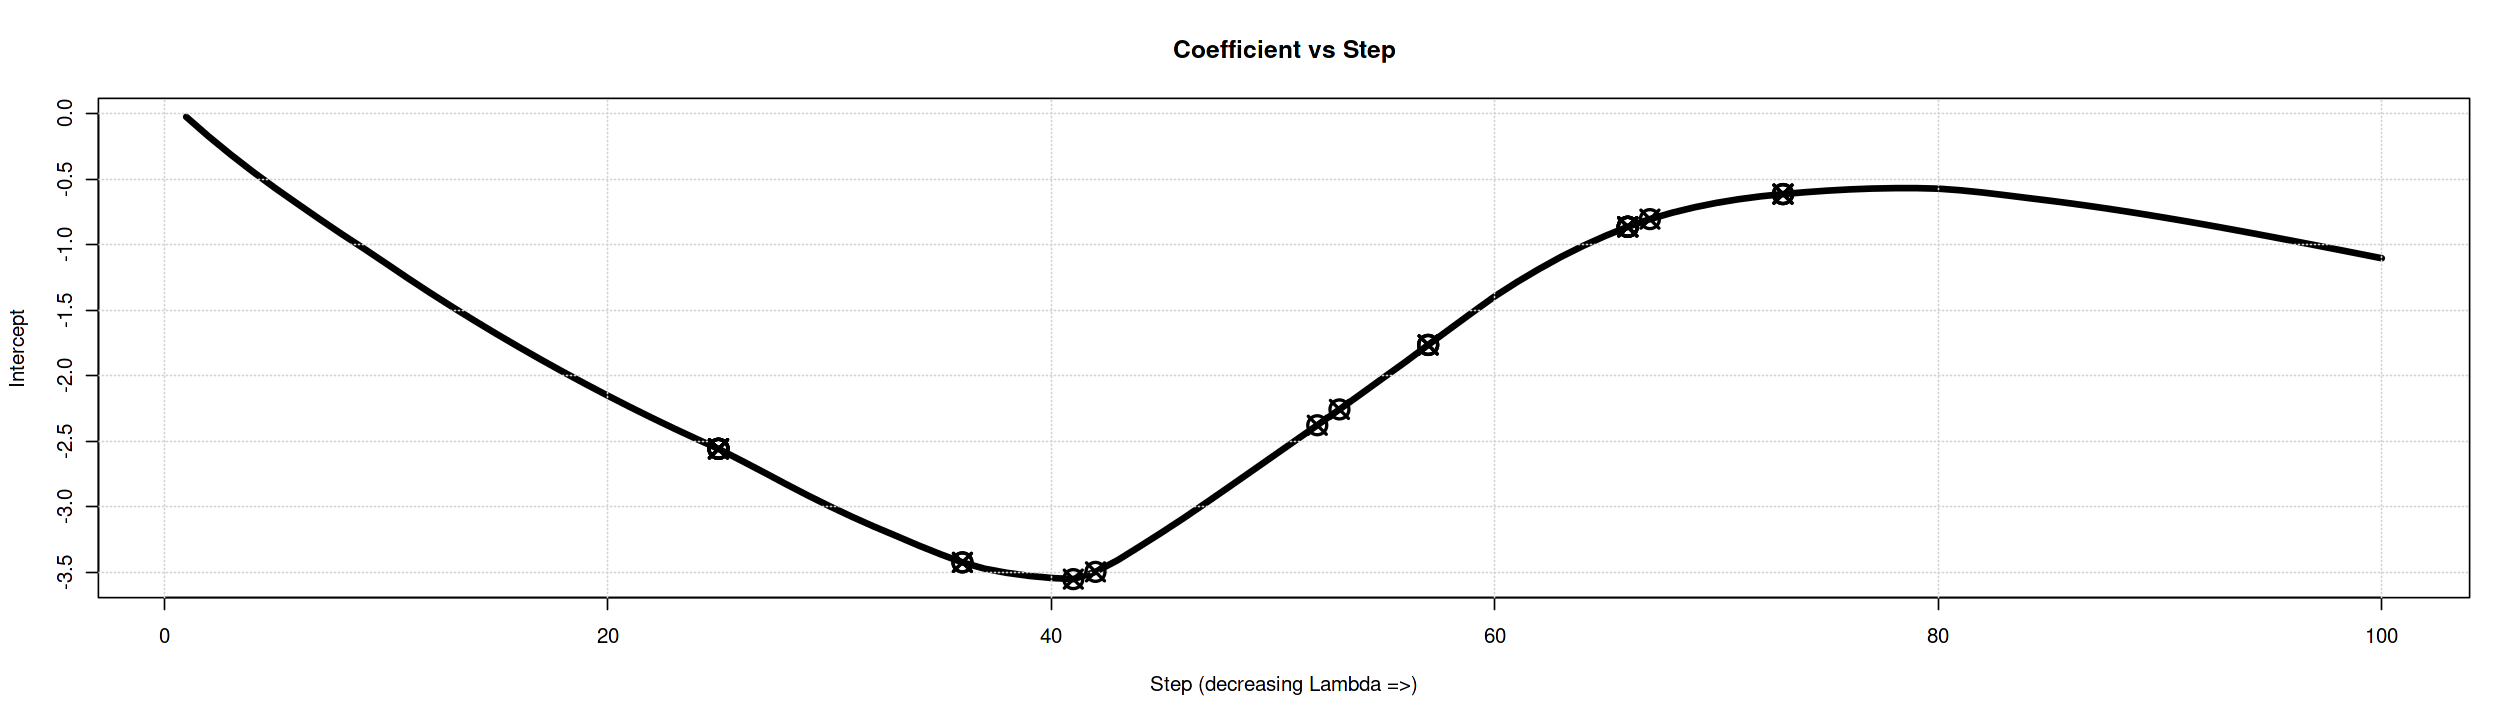

In [45]:
# get entrance point of each group
startx=seq(1:25)*0
starty=seq(1:25)*0
for (i in 1:25){
  first = min(which(cat1==i))
  startx[i] = max(which(coef.matgg[first,]==0))
  starty[i] = fitgg$b0[startx[i]]
}

plot(fitgg$b0,main="Coefficient vs Step",
     ylab="Intercept",xlab="Step (decreasing Lambda =>)",
     type="l",lwd=4)
grid()

points(startx, starty, pch=13, lwd=2, cex=2)

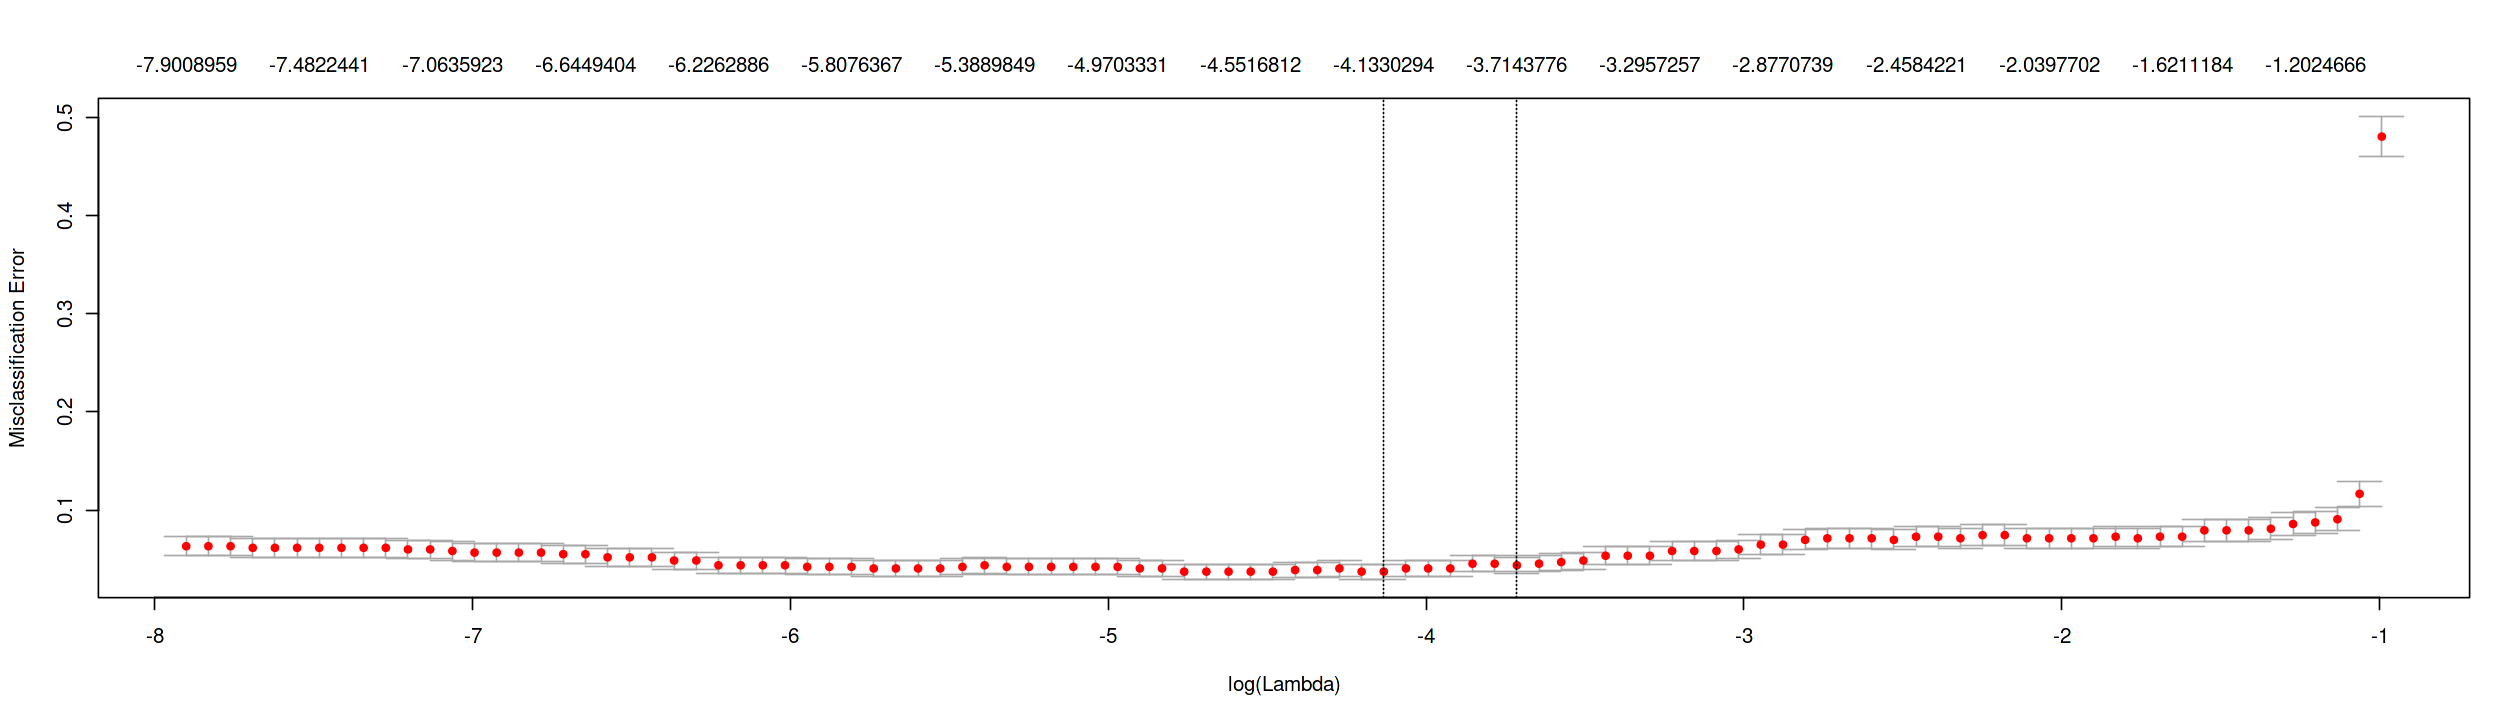

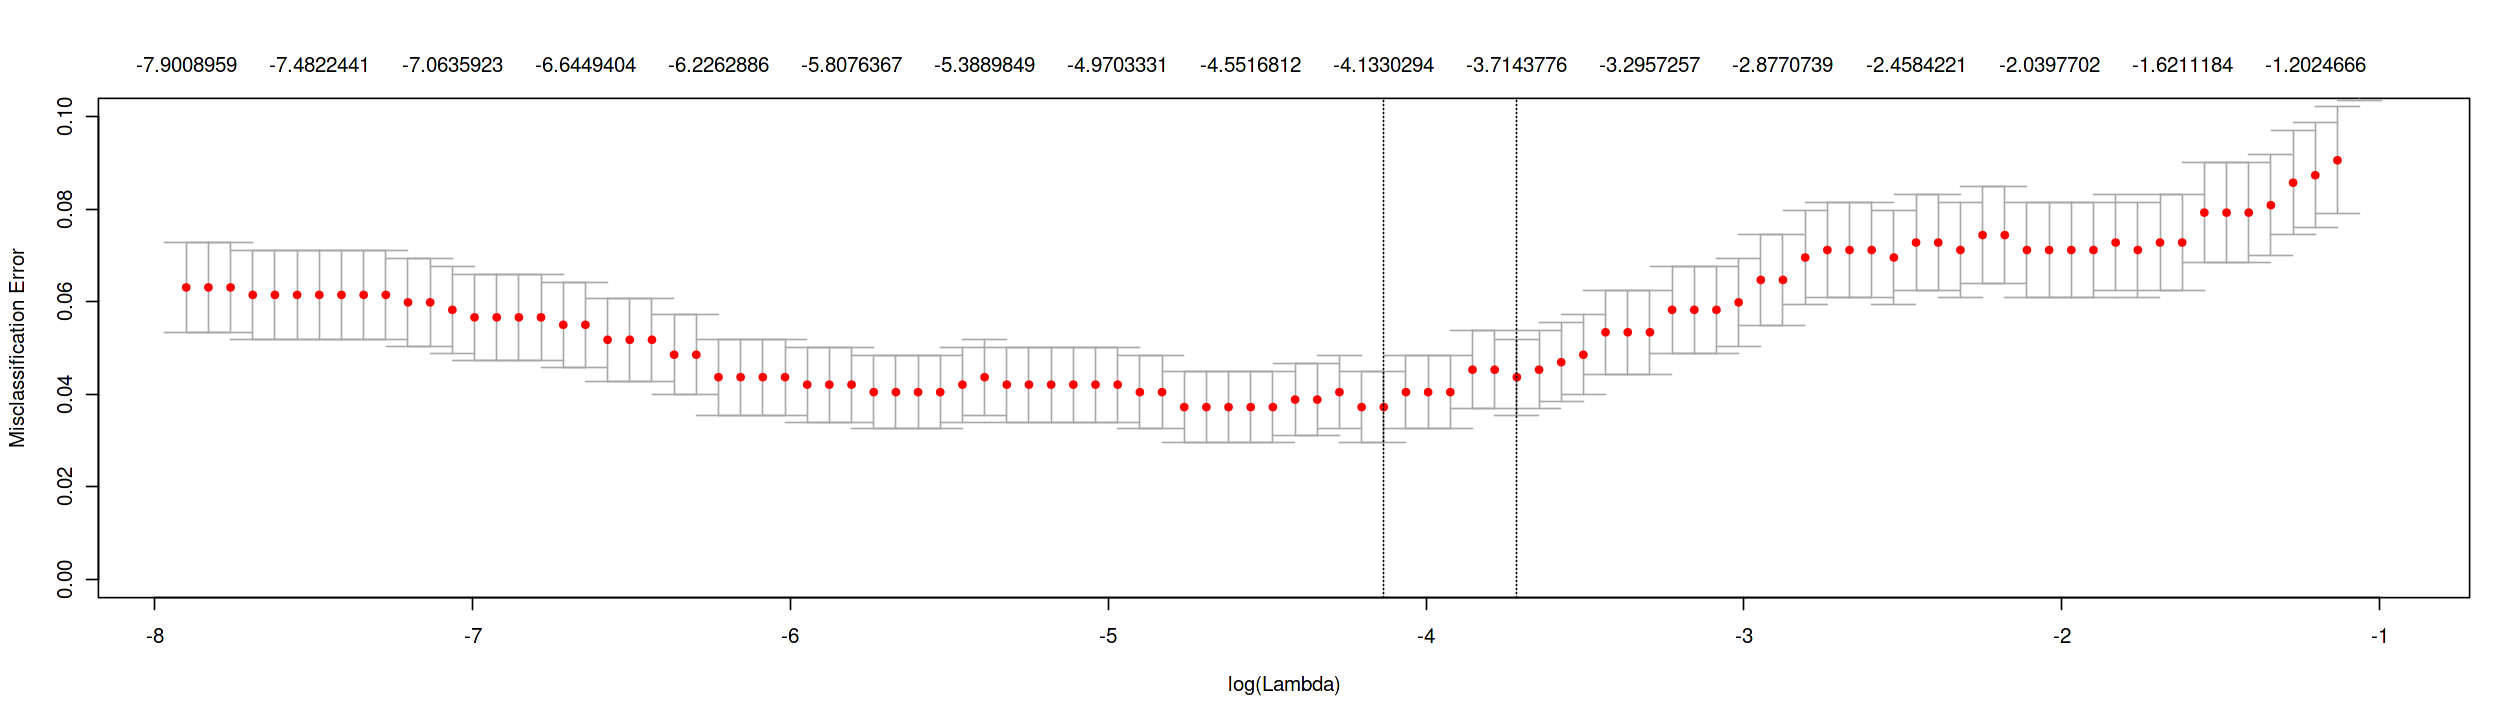

In [46]:
# Cross-Validation (not sure about loss, try also 'misclass')
set.seed(333)
fitgg.cv = cv.gglasso(x_train, y_train, group=cat1, nfolds=10, pred.loss='misclass', loss='logit')
plot(fitgg.cv)
plot(fitgg.cv, ylim=c(0, 0.1))

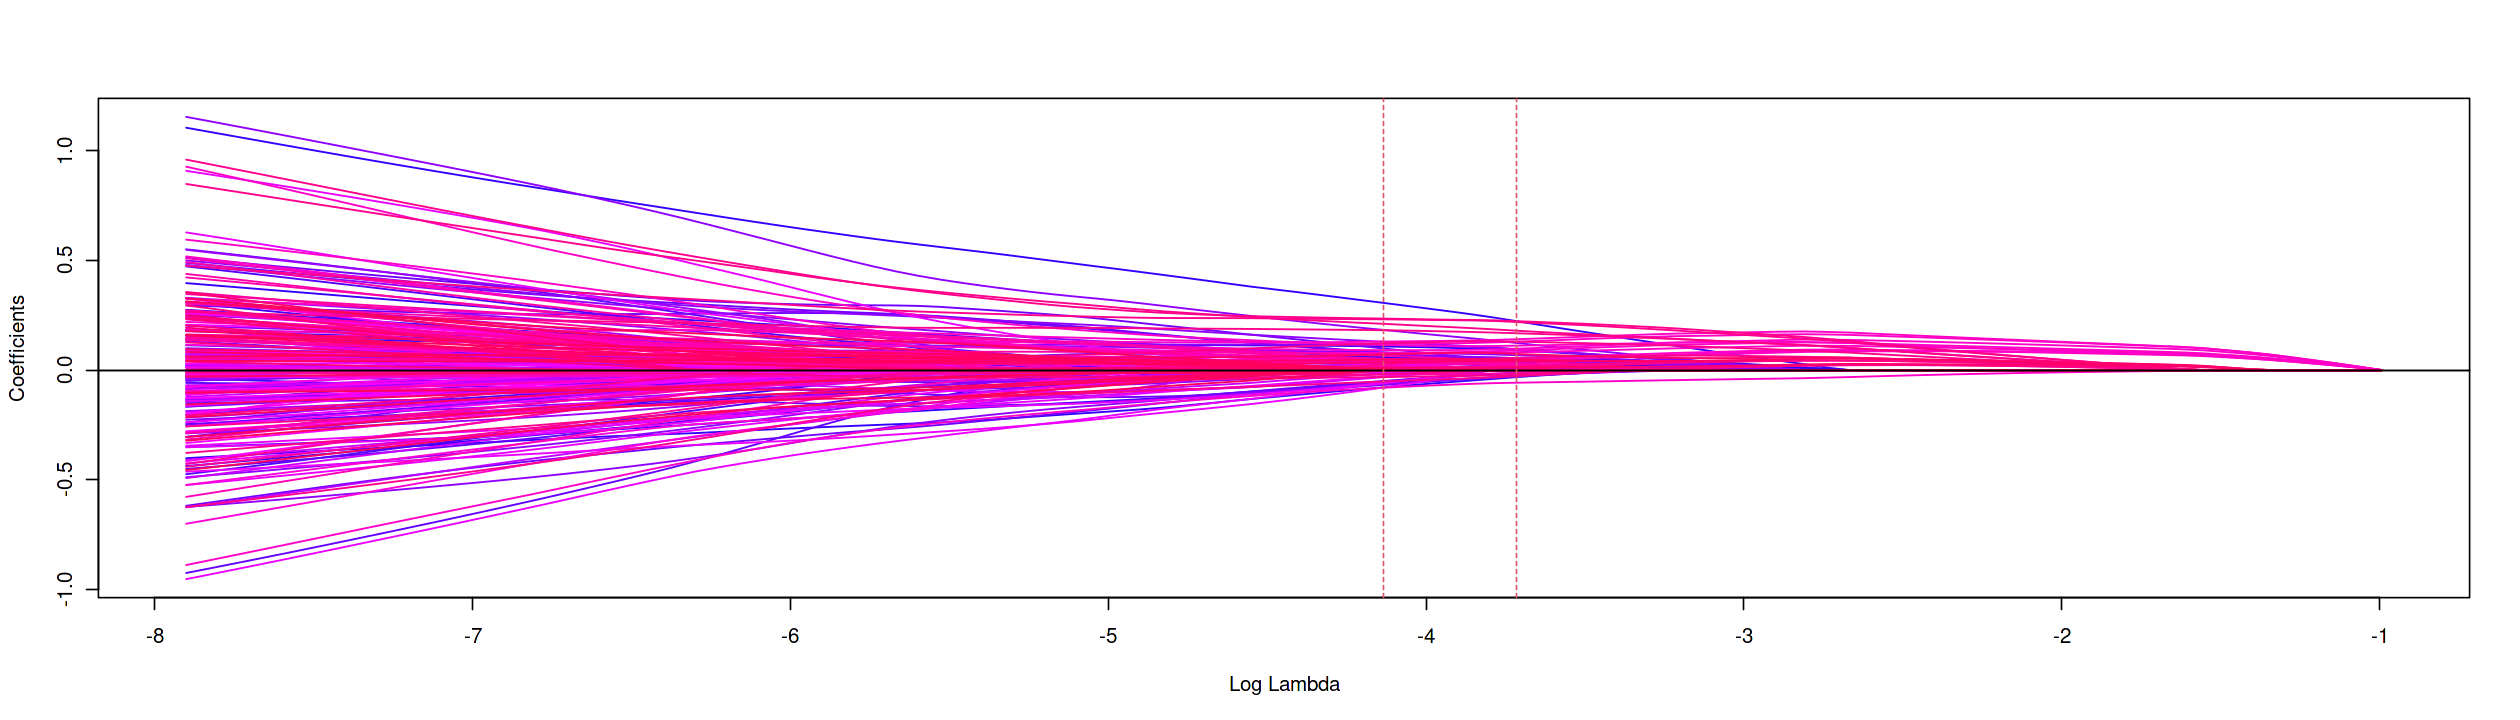

In [47]:
lmbdagg = fitgg.cv$lambda.1se
lmbdagg1 = fitgg.cv$lambda.min
plot(fitgg)
abline(v=log(lmbdagg), lty=2, col=2)
abline(v=log(lmbdagg1), lty=2, col=2)

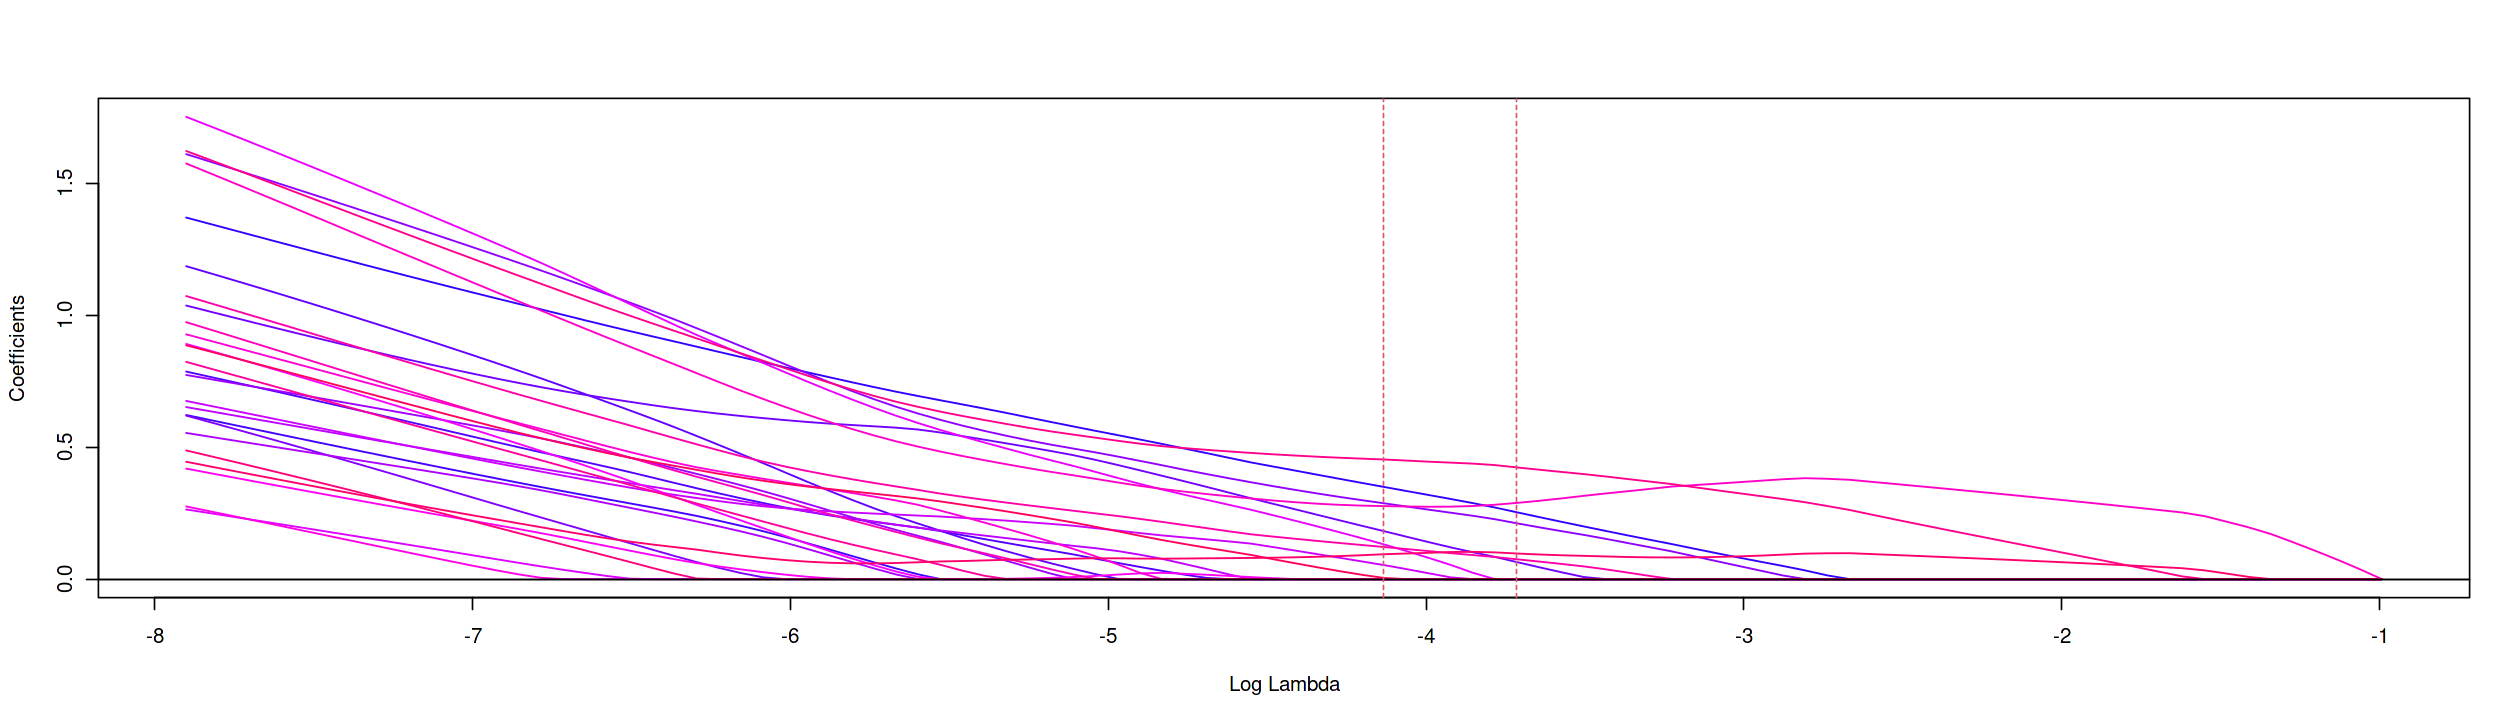

In [48]:
plot(fitgg, group=TRUE)
abline(v=log(lmbdagg), lty=2, col=2)
abline(v=log(lmbdagg1), lty=2, col=2)

In [49]:
coefs = coef(object=fitgg, s=lmbdagg)
coefs1 = coef(object=fitgg, s=lmbdagg1)
cbind(coefs, coefs1)

1            1            
(Intercept) -3.54417496  -3.084702800 
Q1           0.08941878   0.107645763 
Q2           0.22272690   0.306156774 
Q3           0.01507878   0.004713178 
Q4           0.05499227   0.059881292 
Q5          -0.03202046  -0.078713604 
Q6          -0.02705636  -0.060004008 
Q7           0.03954132   0.058913757 
Q8           0.00000000   0.000000000 
Q9           0.00000000   0.000000000 
Q10          0.00000000   0.000000000 
Q11          0.00000000   0.000000000 
Q12          0.00000000   0.000000000 
Q13          0.00000000   0.000000000 
Q14          0.00000000   0.000000000 
Q15          0.00000000   0.000000000 
Q16          0.00000000   0.000000000 
Q17          0.00000000   0.000000000 
Q18          0.00000000   0.000000000 
Q19          0.00000000   0.000000000 
Q20          0.00000000   0.000000000 
Q21          0.00000000   0.000000000 
Q22          0.00000000   0.000000000 
Q23          0.00000000   0.000000000 
Q24          0.00000000   0.000000000 
Q25          0.00000000   0.000000000 
Q26          0.00000000   0.000000000 
Q27          0.00000000   0.000000000 
Q28          0.00000000   0.000000000 
Q29          0.00000000   0.000000000 
⋮           ⋮            ⋮            
Q191        -0.019594836 -0.0318061930
Q192         0.218992253  0.2314140490
Q193         0.002957601 -0.0187688311
Q194         0.014865476 -0.0026967997
Q195         0.179475149  0.2108322778
Q196         0.000000000  0.0000000000
Q197         0.000000000  0.0000000000
Q198         0.000000000  0.0000000000
Q199         0.000000000  0.0000000000
Q200         0.000000000  0.0000000000
Q201         0.000000000  0.0000000000
Q202         0.000000000  0.0000000000
Q203         0.073530183  0.0719892499
Q204         0.011474978  0.0098895407
Q205         0.040491923  0.0357022094
Q206         0.047373554  0.0483115747
Q207         0.000000000  0.0017500445
Q208         0.000000000  0.0017946629
Q209         0.000000000  0.0010995877
Q210         0.000000000  0.0007863968
Q211         0.000000000 -0.0009724066
Q212         0.000000000 -0.0022689112
Q213         0.000000000  0.0001421709
Q214         0.000000000 -0.0009921127
Q215         0.000000000 -0.0006270729
Q216         0.000000000  0.0001925285
Q217         0.000000000  0.0015987331
Q218         0.000000000 -0.0004519070
Q219         0.000000000  0.0012577433
Q220         0.000000000  0.0008267996

In [50]:
plt = cbind(y_test, predict(object=fitgg, newx=x_test, s=lmbdagg),
            predict(object=fitgg, newx=x_test, s=lmbdagg1))

table(plt[,2], plt[,1]) #confusion matrix
table(plt[,3], plt[,1])

    
      -1   1
  -1  96   6
  1    3 101

    
      -1   1
  -1  96   5
  1    3 102

# 4 Conclusion
Comparing all the methods that we used, it seems penalized logistic regression provides a more accurate and simpler model. Considering our aim which was detecting dishonest objects, penalized logistic regression can recognize them based on 40 specific questions out of 220 questions that were asked in this questionary.